In [1]:
import sys
import pandas as pd
import numpy as np
import os
from functools import reduce
import datetime
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import (
    auc,
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.model_selection import GridSearchCV, train_test_split

sys.path.append("..")

from shift_detector import *
from shift_reductor import *
from shift_experiments import *
from shift_explainer import *
from shift_tester import *
from shift_utils import *
from shift_models import *
from shift_constants import *
from shift_plot_utils import *

import sqlalchemy
from sqlalchemy import select, func, extract, desc
from sqlalchemy.sql.expression import and_

from evidently import ColumnMapping
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataQualityTab
from evidently.model_profile import Profile
from evidently.model_profile.sections import DataQualityProfileSection

import cyclops.config
from cyclops.processors.column_names import (
    ENCOUNTER_ID,
    HOSPITAL_ID,
    ADMIT_TIMESTAMP,
    DISCHARGE_TIMESTAMP,
    DISCHARGE_DISPOSITION,
    READMISSION,
    AGE,
    SEX,
    TOTAL_COST,
    CITY,
    PROVINCE,
    COUNTRY,
    LANGUAGE,
    LENGTH_OF_STAY_IN_ER,
    REFERENCE_RANGE,
)

2022-04-29 11:32:00.333545: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/R/4.0.4/lib/R/lib::/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/usr/lib/jvm/java-11-openjdk-amd64/lib/server
2022-04-29 11:32:00.333619: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-04-29 11:32:06,894 INFO cyclops.config  - Log file is /mnt/nfs/home/krishnanam/vector-delirium/log.log
2022-04-29 11:32:06,910 INFO cyclops.utils.profile - Log file is /mnt/nfs/home/krishnanam/vector-delirium/log.log
2022-04-29 11:32:06,916 INFO cyclops.processors.impute - Log file is /mnt/nfs/home/krishnanam/vector-delirium/log.log
2022-04-29 11:32:06,923 INFO cyclops.feature_handler - Log file is /mnt/nfs/home/krishnanam/vector-delirium/log.log
2022-04-29 11:32:06,93

# Parameters #

In [2]:
PATH = "/mnt/nfs/project/delirium/drift_exp/"
PATH = "/mnt/nfs/project/delirium/sprint_demo/APR-28-2022/"
DATASET = "gemini"
SAMPLES = [10, 20, 50, 100, 200, 500, 1000, 2000]
RANDOM_RUNS = 5
SIGN_LEVEL = 0.05
calc_acc = True
SAMPLES = [10, 20, 50, 100, 200, 500, 1000, 2000]
SHIFTS = ["pre-covid", "covid", "summer", "winter", "seasonal"]
OUTCOMES = ["length_of_stay_in_er", "mortality_in_hospital"]
HOSPITALS = ["SMH", "MSH", "THPC", "THPM", "UHNTG", "UHNTW"]
HOSPITALS = ["SMH", "MSH"]
DR_TECHNIQUES = ["NoRed", "SRP", "PCA", "BBSDs_FFNN"]
MD_TESTS = ["MMD", "LK", "LSDD"]

# Load Data #

In [3]:
SHIFT_EXPERIMENT = input("Select experiment: ")
OUTCOME = input("Select outcome variable: ")
if SHIFT_EXPERIMENT != "hosp_type":
    HOSPITAL = [input("Select hospital: ")]
NA_CUTOFF = 0.60

if SHIFT_EXPERIMENT == "covid":
    SHIFT_BS = ["pre-covid", "covid"]

if SHIFT_EXPERIMENT == "seasonal":
    SHIFT_BS = ["summer", "winter", "seasonal"]
    
(
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test),
    feats,
    orig_dims,
) = import_dataset_hospital(
    SHIFT_EXPERIMENT, OUTCOME, HOSPITAL, NA_CUTOFF, shuffle=True
)

Select experiment: covid
Select outcome variable: length_of_stay_in_er
Select hospital: MSH


# Drift Tests #

pre-covid | SMH | NoRed | MMD
Shift pre-covid


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.14000000059604645
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.8199999928474426
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5400000214576721
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.75
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.6600000262260437
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.8700000047683716
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7699999809265137
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8100000023841858
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.5
Random Run 0 : Sample 20
Shift p-vals:  0.5099999904632568
Random Run 0 : Sample 50
Shift p-vals:  0.8199999928474426
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.5400000214576721
Random Run 0 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.27000001072883606
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.14000000059604645
Random Run 0 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.9100000262260437
Random Run 0 : Sample 2000
Shift p-vals:  0.6399999856948853


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.28999999165534973
Random Run 1 : Sample 20
Shift p-vals:  0.17000000178813934
Random Run 1 : Sample 50
Shift p-vals:  1.0
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.8799999952316284
Random Run 1 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.10000000149011612
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.07000000029802322
Random Run 1 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.550000011920929
Random Run 1 : Sample 2000
Shift p-vals:  0.36000001430511475


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.8799999952316284
Random Run 2 : Sample 20
Shift p-vals:  0.4399999976158142
Random Run 2 : Sample 50
Shift p-vals:  0.8799999952316284
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.8600000143051147
Random Run 2 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.5099999904632568
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.4699999988079071
Random Run 2 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.6700000166893005
Random Run 2 : Sample 2000
Shift p-vals:  0.6700000166893005


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.4300000071525574
Random Run 3 : Sample 20
Shift p-vals:  0.10000000149011612
Random Run 3 : Sample 50
Shift p-vals:  0.46000000834465027
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.8700000047683716
Random Run 3 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.25
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.5899999737739563
Random Run 3 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.6800000071525574
Random Run 3 : Sample 2000
Shift p-vals:  0.44999998807907104


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.10999999940395355
Random Run 4 : Sample 20
Shift p-vals:  0.1899999976158142
Random Run 4 : Sample 50
Shift p-vals:  0.6800000071525574
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.6299999952316284
Random Run 4 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.699999988079071
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.9200000166893005
Random Run 4 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.8199999928474426
Random Run 4 : Sample 2000
Shift p-vals:  0.9599999785423279
pre-covid | SMH | NoRed | LSDD
Shift pre-covid


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5400000214576721
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.38999998569488525
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.47999998927116394
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.8799999952316284
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.3499999940395355
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.9200000166893005
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 1 : Sample 50
No GPU detected, fall

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.11999999731779099
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.46000000834465027
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.9300000071525574
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.6499999761581421
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.11999999731779099
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.949999988079071
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.0

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.5299999713897705
Random Run 0 : Sample 20
Shift p-vals:  0.5
Random Run 0 : Sample 50
Shift p-vals:  0.3400000035762787
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.28999999165534973
Random Run 0 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.6700000166893005
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.28999999165534973
Random Run 0 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.47999998927116394
Random Run 0 : Sample 2000
Shift p-vals:  0.9200000166893005


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.1899999976158142
Random Run 1 : Sample 20
Shift p-vals:  0.5299999713897705
Random Run 1 : Sample 50
Shift p-vals:  0.4000000059604645
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.14000000059604645
Random Run 1 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.5899999737739563
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.3199999928474426
Random Run 1 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.23000000417232513
Random Run 1 : Sample 2000
Shift p-vals:  0.7900000214576721


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.15000000596046448
Random Run 2 : Sample 20
Shift p-vals:  0.8100000023841858
Random Run 2 : Sample 50
Shift p-vals:  0.28999999165534973
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.9900000095367432
Random Run 2 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.3199999928474426
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.6399999856948853
Random Run 2 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.029999999329447746
Random Run 2 : Sample 2000
Shift p-vals:  0.8299999833106995


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  1.0
Random Run 3 : Sample 20
Shift p-vals:  0.2199999988079071
Random Run 3 : Sample 50
Shift p-vals:  0.4699999988079071
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.949999988079071
Random Run 3 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.20999999344348907
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.6499999761581421
Random Run 3 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.5099999904632568
Random Run 3 : Sample 2000
Shift p-vals:  0.6600000262260437


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.8500000238418579
Random Run 4 : Sample 20
Shift p-vals:  0.5699999928474426
Random Run 4 : Sample 50
Shift p-vals:  0.7900000214576721
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.38999998569488525
Random Run 4 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.7300000190734863
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.6299999952316284
Random Run 4 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.1599999964237213
Random Run 4 : Sample 2000
Shift p-vals:  0.6399999856948853
pre-covid | SMH | SRP | LSDD
Shift pre-covid


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.1599999964237213
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.7099999785423279
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.2199999988079071
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.6499999761581421
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.3499999940395355
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5600000023841858
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9599999785423279
Random Run 1 : Sample 50
No GPU detected, fall back

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.7799999713897705
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5400000214576721
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8299999833106995
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.7099999785423279
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.8199999928474426
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.8899999856948853
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9100000262260437
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.5400000214576721
Random Run 0 : Sample 20
Shift p-vals:  0.4699999988079071
Random Run 0 : Sample 50
Shift p-vals:  0.6600000262260437
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.3700000047683716
Random Run 0 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.20000000298023224
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.9300000071525574
Random Run 0 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.10999999940395355
Random Run 0 : Sample 2000
Shift p-vals:  0.38999998569488525


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.33000001311302185
Random Run 1 : Sample 20
Shift p-vals:  0.550000011920929
Random Run 1 : Sample 50
Shift p-vals:  0.28999999165534973
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.949999988079071
Random Run 1 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.36000001430511475
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.4000000059604645
Random Run 1 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.23999999463558197
Random Run 1 : Sample 2000
Shift p-vals:  0.009999999776482582


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.5400000214576721
Random Run 2 : Sample 20
Shift p-vals:  0.0
Random Run 2 : Sample 50
Shift p-vals:  0.019999999552965164
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.5600000023841858
Random Run 2 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.8100000023841858
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.6100000143051147
Random Run 2 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.7599999904632568
Random Run 2 : Sample 2000
Shift p-vals:  0.03999999910593033


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.33000001311302185
Random Run 3 : Sample 20
Shift p-vals:  0.9700000286102295
Random Run 3 : Sample 50
Shift p-vals:  0.6600000262260437
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.5699999928474426
Random Run 3 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.07000000029802322
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.009999999776482582
Random Run 3 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.3799999952316284
Random Run 3 : Sample 2000
Shift p-vals:  0.9300000071525574


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.14000000059604645
Random Run 4 : Sample 20
Shift p-vals:  0.9300000071525574
Random Run 4 : Sample 50
Shift p-vals:  0.05999999865889549
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.6499999761581421
Random Run 4 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.800000011920929
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.3199999928474426
Random Run 4 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.8500000238418579
Random Run 4 : Sample 2000
Shift p-vals:  0.9300000071525574
pre-covid | SMH | PCA | LSDD
Shift pre-covid


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8700000047683716
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.7099999785423279
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.3799999952316284
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8700000047683716
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.8799999952316284
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.9300000071525574
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.9900000095367432
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6299999952316284
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.6499999761581421
Random Run 1 : Sample 50
No GPU detected, fall back 

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.36000001430511475
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.6499999761581421
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.7799999713897705
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.41999998688697815
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.5799999833106995
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.6000000238418579
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.3100000023841858
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.75
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5299999713897705
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shi

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.14000000059604645
Random Run 0 : Sample 20
Shift p-vals:  0.6499999761581421
Random Run 0 : Sample 50
Shift p-vals:  0.9100000262260437
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.7099999785423279
Random Run 0 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.0
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.07000000029802322
Random Run 0 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.029999999329447746
Random Run 0 : Sample 2000
Shift p-vals:  0.7300000190734863


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.8999999761581421
Random Run 1 : Sample 20
Shift p-vals:  0.23999999463558197
Random Run 1 : Sample 50
Shift p-vals:  0.6200000047683716
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.9900000095367432
Random Run 1 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.3400000035762787
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.30000001192092896
Random Run 1 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.38999998569488525
Random Run 1 : Sample 2000
Shift p-vals:  0.5600000023841858


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.75
Random Run 2 : Sample 20
Shift p-vals:  0.4099999964237213
Random Run 2 : Sample 50
Shift p-vals:  0.029999999329447746
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.49000000953674316
Random Run 2 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.6299999952316284
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.25
Random Run 2 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.2800000011920929
Random Run 2 : Sample 2000
Shift p-vals:  0.9700000286102295


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.5600000023841858
Random Run 3 : Sample 20
Shift p-vals:  0.38999998569488525
Random Run 3 : Sample 50
Shift p-vals:  0.7900000214576721
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.9100000262260437
Random Run 3 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.17000000178813934
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.3199999928474426
Random Run 3 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.10000000149011612
Random Run 3 : Sample 2000
Shift p-vals:  0.12999999523162842


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.05000000074505806
Random Run 4 : Sample 20
Shift p-vals:  0.5299999713897705
Random Run 4 : Sample 50
Shift p-vals:  0.30000001192092896
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.20999999344348907
Random Run 4 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.8600000143051147
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.1599999964237213
Random Run 4 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.9100000262260437
Random Run 4 : Sample 2000
Shift p-vals:  0.9700000286102295
pre-covid | SMH | BBSDs_FFNN | LSDD
Shift pre-covid


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.18000000715255737
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.6600000262260437
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.800000011920929
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.25999999046325684
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.9100000262260437
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.28999999165534973
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7099999785423279
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.2199999988079071
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5899999737739563
Random Run 1 : Sample 50
No GPU detected, fall ba

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9100000262260437
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.3799999952316284
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.05999999865889549
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7099999785423279
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.7099999785423279
Random Run 1 : Sample 50
No GPU detected, fal

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.30000001192092896
Random Run 0 : Sample 20
Shift p-vals:  0.05999999865889549
Random Run 0 : Sample 50
Shift p-vals:  0.41999998688697815
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.800000011920929
Random Run 0 : Sample 200
Shift p-vals:  1.0
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.9599999785423279
Random Run 0 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.46000000834465027
Random Run 0 : Sample 2000
Shift p-vals:  0.7900000214576721


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.25999999046325684
Random Run 1 : Sample 20
Shift p-vals:  0.6600000262260437
Random Run 1 : Sample 50
Shift p-vals:  0.1899999976158142
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.5
Random Run 1 : Sample 200
Shift p-vals:  0.6899999976158142
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.5600000023841858
Random Run 1 : Sample 1000
Shift p-vals:  0.8299999833106995
Random Run 1 : Sample 2000


No GPU detected, fall back on CPU.


Shift p-vals:  0.05000000074505806


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.5299999713897705
Random Run 2 : Sample 20
Shift p-vals:  0.20000000298023224
Random Run 2 : Sample 50
Shift p-vals:  0.2800000011920929
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.4099999964237213
Random Run 2 : Sample 200
Shift p-vals:  0.23999999463558197
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.8399999737739563
Random Run 2 : Sample 1000
Shift p-vals:  0.25999999046325684
Random Run 2 : Sample 2000


No GPU detected, fall back on CPU.


Shift p-vals:  0.5699999928474426


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.8999999761581421
Random Run 3 : Sample 20
Shift p-vals:  0.4099999964237213
Random Run 3 : Sample 50
Shift p-vals:  0.07999999821186066
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.12999999523162842
Random Run 3 : Sample 200
Shift p-vals:  0.4300000071525574
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.23999999463558197
Random Run 3 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.20000000298023224
Random Run 3 : Sample 2000
Shift p-vals:  0.3799999952316284


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.800000011920929
Random Run 4 : Sample 20
Shift p-vals:  0.07000000029802322
Random Run 4 : Sample 50
Shift p-vals:  0.9399999976158142
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.6000000238418579
Random Run 4 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.75
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.6200000047683716
Random Run 4 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.5
Random Run 4 : Sample 2000
Shift p-vals:  0.550000011920929
pre-covid | MSH | NoRed | LSDD
Shift pre-covid


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.7599999904632

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.41999998688697815
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.75
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.4300000071525574
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.6100000143051147
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.3400000035762787
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.6399999856948853
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7200000286102295
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5699999928474426
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.91

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.6399999856948853
Random Run 0 : Sample 20
Shift p-vals:  0.12999999523162842
Random Run 0 : Sample 50
Shift p-vals:  0.10000000149011612
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.2199999988079071
Random Run 0 : Sample 200
Shift p-vals:  0.8600000143051147
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.30000001192092896
Random Run 0 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.5
Random Run 0 : Sample 2000
Shift p-vals:  0.3400000035762787


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.17000000178813934
Random Run 1 : Sample 20
Shift p-vals:  0.7200000286102295
Random Run 1 : Sample 50
Shift p-vals:  0.36000001430511475
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.5099999904632568
Random Run 1 : Sample 200
Shift p-vals:  0.6399999856948853
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.7099999785423279
Random Run 1 : Sample 1000
Shift p-vals:  0.75
Random Run 1 : Sample 2000


No GPU detected, fall back on CPU.


Shift p-vals:  0.7300000190734863


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.5899999737739563
Random Run 2 : Sample 20
Shift p-vals:  0.2199999988079071
Random Run 2 : Sample 50
Shift p-vals:  0.550000011920929
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.8299999833106995
Random Run 2 : Sample 200
Shift p-vals:  0.8600000143051147
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.4399999976158142
Random Run 2 : Sample 1000
Shift p-vals:  0.4000000059604645
Random Run 2 : Sample 2000


No GPU detected, fall back on CPU.


Shift p-vals:  0.07999999821186066


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.550000011920929
Random Run 3 : Sample 20
Shift p-vals:  0.6000000238418579
Random Run 3 : Sample 50
Shift p-vals:  0.20000000298023224
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.4099999964237213
Random Run 3 : Sample 200
Shift p-vals:  0.7799999713897705
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.6800000071525574
Random Run 3 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.9200000166893005
Random Run 3 : Sample 2000
Shift p-vals:  0.33000001311302185


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.46000000834465027
Random Run 4 : Sample 20
Shift p-vals:  0.4099999964237213
Random Run 4 : Sample 50
Shift p-vals:  0.4699999988079071
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.9900000095367432
Random Run 4 : Sample 200
Shift p-vals:  0.550000011920929
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.1899999976158142
Random Run 4 : Sample 1000
Shift p-vals:  0.8100000023841858
Random Run 4 : Sample 2000


No GPU detected, fall back on CPU.
torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Shift p-vals:  0.75
pre-covid | MSH | SRP | LSDD
Shift pre-covid
Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.20999999344348907
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9599999785423279
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.23999999463558197
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.6700000166893005
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.27000001072883606
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.05999999865889549
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.9399999976158142
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.7799999713897705
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.41999998688697815
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.11999999731779099
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8799999952316284
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.6899999976158142
Random Run 1 : Sample 50
No GPU detected, fall

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.6000000238418579
Random Run 0 : Sample 20
Shift p-vals:  0.3799999952316284
Random Run 0 : Sample 50
Shift p-vals:  0.41999998688697815
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.25
Random Run 0 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.23000000417232513
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.03999999910593033
Random Run 0 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.7400000095367432
Random Run 0 : Sample 2000
Shift p-vals:  0.9399999976158142


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.6100000143051147
Random Run 1 : Sample 20
Shift p-vals:  0.4099999964237213
Random Run 1 : Sample 50
Shift p-vals:  0.2800000011920929
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.8399999737739563
Random Run 1 : Sample 200
Shift p-vals:  0.949999988079071
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.019999999552965164
Random Run 1 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.8299999833106995
Random Run 1 : Sample 2000
Shift p-vals:  0.1899999976158142


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.10999999940395355
Random Run 2 : Sample 20
Shift p-vals:  0.5699999928474426
Random Run 2 : Sample 50
Shift p-vals:  0.7799999713897705
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.6600000262260437
Random Run 2 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.7099999785423279
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.18000000715255737
Random Run 2 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.9200000166893005
Random Run 2 : Sample 2000
Shift p-vals:  0.6299999952316284


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.07999999821186066
Random Run 3 : Sample 20
Shift p-vals:  0.5199999809265137
Random Run 3 : Sample 50
Shift p-vals:  0.10000000149011612
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.75
Random Run 3 : Sample 200
Shift p-vals:  0.8600000143051147
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.7699999809265137
Random Run 3 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.7900000214576721
Random Run 3 : Sample 2000
Shift p-vals:  0.10999999940395355


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.4300000071525574
Random Run 4 : Sample 20
Shift p-vals:  0.2199999988079071
Random Run 4 : Sample 50
Shift p-vals:  0.3499999940395355
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.11999999731779099
Random Run 4 : Sample 200
Shift p-vals:  0.9900000095367432
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.5799999833106995
Random Run 4 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.4099999964237213
Random Run 4 : Sample 2000
Shift p-vals:  0.009999999776482582
pre-covid | MSH | PCA | LSDD
Shift pre-covid


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.9599999785423279
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5400000214576721
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.1599999964237213
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.3799999952316284
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.44999998807907104
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8100000023841858
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8100000023841858
Random Run 1 : Sample 50
No GPU detected, fall ba

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.9300000071525574
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.7099999785423279
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.5799999833106995
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.5199999809265137
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8799999952316284
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.1599999964237213
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shif

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.07000000029802322
Random Run 0 : Sample 20
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 50
Shift p-vals:  0.5899999737739563
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.4000000059604645
Random Run 0 : Sample 200
Shift p-vals:  0.5199999809265137
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.949999988079071
Random Run 0 : Sample 1000
Shift p-vals:  0.7799999713897705
Random Run 0 : Sample 2000


No GPU detected, fall back on CPU.


Shift p-vals:  0.9800000190734863


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.4399999976158142
Random Run 1 : Sample 20
Shift p-vals:  0.07000000029802322
Random Run 1 : Sample 50
Shift p-vals:  0.6000000238418579
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.1599999964237213
Random Run 1 : Sample 200
Shift p-vals:  0.009999999776482582
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.8899999856948853
Random Run 1 : Sample 1000
Shift p-vals:  0.18000000715255737
Random Run 1 : Sample 2000


No GPU detected, fall back on CPU.


Shift p-vals:  0.5400000214576721


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.41999998688697815
Random Run 2 : Sample 20
Shift p-vals:  0.3100000023841858
Random Run 2 : Sample 50
Shift p-vals:  0.30000001192092896
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.8500000238418579
Random Run 2 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.6399999856948853
Random Run 2 : Sample 500
Shift p-vals:  0.7699999809265137
Random Run 2 : Sample 1000


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.8500000238418579
Random Run 2 : Sample 2000
Shift p-vals:  0.8600000143051147


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.7400000095367432
Random Run 3 : Sample 20
Shift p-vals:  0.5799999833106995
Random Run 3 : Sample 50
Shift p-vals:  0.1899999976158142
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.47999998927116394
Random Run 3 : Sample 200
Shift p-vals:  0.949999988079071
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.8199999928474426
Random Run 3 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  1.0
Random Run 3 : Sample 2000
Shift p-vals:  0.009999999776482582


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.38999998569488525
Random Run 4 : Sample 20
Shift p-vals:  0.09000000357627869
Random Run 4 : Sample 50
Shift p-vals:  0.699999988079071
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.3100000023841858
Random Run 4 : Sample 200
Shift p-vals:  0.6399999856948853
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.46000000834465027
Random Run 4 : Sample 1000
Shift p-vals:  0.11999999731779099
Random Run 4 : Sample 2000


No GPU detected, fall back on CPU.
torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Shift p-vals:  0.6899999976158142
pre-covid | MSH | BBSDs_FFNN | LSDD
Shift pre-covid
Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9900000095367432
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.5400000214576721
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.9399999976158142
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.33000001311302185
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.41999998688697815
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6200000047683716
Random Run 1 : Sample 20
No GPU detected, fall back on C

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.05999999865889549
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 1 : Sample 100

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.5299999713897705
Random Run 0 : Sample 20
Shift p-vals:  0.28999999165534973
Random Run 0 : Sample 50
Shift p-vals:  0.44999998807907104
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.9200000166893005
Random Run 0 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.5799999833106995
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.6499999761581421
Random Run 0 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.949999988079071
Random Run 0 : Sample 2000
Shift p-vals:  0.36000001430511475


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.12999999523162842
Random Run 1 : Sample 20
Shift p-vals:  0.05000000074505806
Random Run 1 : Sample 50
Shift p-vals:  0.07999999821186066
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.09000000357627869
Random Run 1 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.7099999785423279
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.8500000238418579
Random Run 1 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.44999998807907104
Random Run 1 : Sample 2000
Shift p-vals:  0.019999999552965164


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.7799999713897705
Random Run 2 : Sample 20
Shift p-vals:  0.7200000286102295
Random Run 2 : Sample 50
Shift p-vals:  0.029999999329447746
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.7099999785423279
Random Run 2 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.27000001072883606
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.4399999976158142
Random Run 2 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.8299999833106995
Random Run 2 : Sample 2000
Shift p-vals:  0.0


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  1.0
Random Run 3 : Sample 20
Shift p-vals:  0.3400000035762787
Random Run 3 : Sample 50
Shift p-vals:  0.25999999046325684
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.46000000834465027
Random Run 3 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.12999999523162842
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.75
Random Run 3 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.6299999952316284
Random Run 3 : Sample 2000
Shift p-vals:  0.07999999821186066


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.75
Random Run 4 : Sample 20
Shift p-vals:  0.9300000071525574
Random Run 4 : Sample 50
Shift p-vals:  0.0
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.7599999904632568
Random Run 4 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.5400000214576721
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.699999988079071
Random Run 4 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.2199999988079071
Random Run 4 : Sample 2000
Shift p-vals:  0.5199999809265137
covid | SMH | NoRed | LSDD
Shift covid


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.14000000059604645
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7099999785423279
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 1 : Sample 100

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.33000001311302185
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9300000071525574
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.3799999952316284
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.3499999940395355
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.3499999940395355
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.11999999731779099


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.949999988079071
Random Run 0 : Sample 20
Shift p-vals:  0.14000000059604645
Random Run 0 : Sample 50
Shift p-vals:  0.49000000953674316
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.27000001072883606
Random Run 0 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.07999999821186066
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.8899999856948853
Random Run 0 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 2000
Shift p-vals:  0.14000000059604645


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.800000011920929
Random Run 1 : Sample 20
Shift p-vals:  0.5400000214576721
Random Run 1 : Sample 50
Shift p-vals:  0.3700000047683716
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.5600000023841858
Random Run 1 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.7599999904632568
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.4000000059604645
Random Run 1 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.8700000047683716
Random Run 1 : Sample 2000
Shift p-vals:  0.019999999552965164


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  1.0
Random Run 2 : Sample 20
Shift p-vals:  0.6700000166893005
Random Run 2 : Sample 50
Shift p-vals:  0.17000000178813934
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.8700000047683716
Random Run 2 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.8399999737739563
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.25999999046325684
Random Run 2 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.6100000143051147
Random Run 2 : Sample 2000
Shift p-vals:  0.4300000071525574


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.8500000238418579
Random Run 3 : Sample 20
Shift p-vals:  0.6000000238418579
Random Run 3 : Sample 50
Shift p-vals:  0.3499999940395355
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.5199999809265137
Random Run 3 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.17000000178813934
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  1.0
Random Run 3 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.6899999976158142
Random Run 3 : Sample 2000
Shift p-vals:  0.07000000029802322


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.44999998807907104
Random Run 4 : Sample 20
Shift p-vals:  0.20000000298023224
Random Run 4 : Sample 50
Shift p-vals:  1.0
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.4399999976158142
Random Run 4 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.05999999865889549
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.4399999976158142
Random Run 4 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.20000000298023224
Random Run 4 : Sample 2000
Shift p-vals:  0.7200000286102295
covid | SMH | SRP | LSDD
Shift covid


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.9200000166893005
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9800000190734863
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.9599999785423279
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8399999737739563
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9900000095367432
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.5
Random Run 1 : Sa

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.14000000059604645
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random R

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.6100000143051147
Random Run 0 : Sample 20
Shift p-vals:  0.23999999463558197
Random Run 0 : Sample 50


No GPU detected, fall back on CPU.


Shift p-vals:  0.6800000071525574
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.4099999964237213
Random Run 0 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.44999998807907104
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.44999998807907104
Random Run 0 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.0
Random Run 0 : Sample 2000
Shift p-vals:  0.07999999821186066


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.25
Random Run 1 : Sample 20
Shift p-vals:  0.8600000143051147
Random Run 1 : Sample 50
Shift p-vals:  0.07000000029802322
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.7799999713897705
Random Run 1 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.49000000953674316
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.9399999976158142
Random Run 1 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.0
Random Run 1 : Sample 2000
Shift p-vals:  0.23999999463558197


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.7599999904632568
Random Run 2 : Sample 20
Shift p-vals:  0.25999999046325684
Random Run 2 : Sample 50
Shift p-vals:  0.6800000071525574
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.23999999463558197
Random Run 2 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.8799999952316284
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.029999999329447746
Random Run 2 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.009999999776482582
Random Run 2 : Sample 2000
Shift p-vals:  0.0


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.12999999523162842
Random Run 3 : Sample 20
Shift p-vals:  0.09000000357627869
Random Run 3 : Sample 50
Shift p-vals:  0.5
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.5099999904632568
Random Run 3 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.03999999910593033
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.009999999776482582
Random Run 3 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.49000000953674316
Random Run 3 : Sample 2000
Shift p-vals:  0.019999999552965164


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.3700000047683716
Random Run 4 : Sample 20
Shift p-vals:  0.7900000214576721
Random Run 4 : Sample 50
Shift p-vals:  0.38999998569488525
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.019999999552965164
Random Run 4 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.4000000059604645
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.07999999821186066
Random Run 4 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.47999998927116394
Random Run 4 : Sample 2000
Shift p-vals:  0.5799999833106995
covid | SMH | PCA | LSDD
Shift covid


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.44999998807907104
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.699999988079071
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5600000023841858
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 1 : Sample 100
No G

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.6499999761581421
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.20000000298023224
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.23999999463558197
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.4000000059604645
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.44999998807907104
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8500000238418579
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.0

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.550000011920929
Random Run 0 : Sample 20
Shift p-vals:  0.8500000238418579
Random Run 0 : Sample 50
Shift p-vals:  0.17000000178813934
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.550000011920929
Random Run 0 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.46000000834465027
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.8199999928474426
Random Run 0 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.029999999329447746
Random Run 0 : Sample 2000
Shift p-vals:  0.699999988079071


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.14000000059604645
Random Run 1 : Sample 20
Shift p-vals:  0.5099999904632568
Random Run 1 : Sample 50
Shift p-vals:  0.4099999964237213
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.12999999523162842
Random Run 1 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.3199999928474426
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.0
Random Run 1 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.5199999809265137
Random Run 1 : Sample 2000
Shift p-vals:  0.0


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.15000000596046448
Random Run 2 : Sample 20
Shift p-vals:  0.550000011920929
Random Run 2 : Sample 50
Shift p-vals:  0.7599999904632568
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.7799999713897705
Random Run 2 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.23000000417232513
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.36000001430511475
Random Run 2 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.36000001430511475
Random Run 2 : Sample 2000
Shift p-vals:  0.5799999833106995


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.9100000262260437
Random Run 3 : Sample 20
Shift p-vals:  0.3199999928474426
Random Run 3 : Sample 50
Shift p-vals:  0.029999999329447746
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.6200000047683716
Random Run 3 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.27000001072883606
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.5
Random Run 3 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.3700000047683716
Random Run 3 : Sample 2000
Shift p-vals:  0.15000000596046448


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.3499999940395355
Random Run 4 : Sample 20
Shift p-vals:  0.6899999976158142
Random Run 4 : Sample 50
Shift p-vals:  0.3400000035762787
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.800000011920929
Random Run 4 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.49000000953674316
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.4300000071525574
Random Run 4 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.8299999833106995
Random Run 4 : Sample 2000
Shift p-vals:  0.0
covid | SMH | BBSDs_FFNN | LSDD
Shift covid


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.20000000298023224
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5799999833106995
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.6499999761581421
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.11999999731779099
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  1.0
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8100000023841858
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6000000238418579
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.41999998688697815
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.3100000023841858
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.7300000190734863
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.6399999856948853
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7099999785423279
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.4300000071525574
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.550000011920929
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.5099999904632568
Random Run 0 : Sample 20
Shift p-vals:  0.4099999964237213
Random Run 0 : Sample 50
Shift p-vals:  0.9700000286102295
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.5600000023841858
Random Run 0 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.1899999976158142
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.5299999713897705
Random Run 0 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.7799999713897705
Random Run 0 : Sample 2000
Shift p-vals:  0.28999999165534973


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.6299999952316284
Random Run 1 : Sample 20
Shift p-vals:  0.6800000071525574
Random Run 1 : Sample 50
Shift p-vals:  0.6100000143051147
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.5099999904632568
Random Run 1 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.25
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.5400000214576721
Random Run 1 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.10000000149011612
Random Run 1 : Sample 2000
Shift p-vals:  0.7599999904632568


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.23999999463558197
Random Run 2 : Sample 20
Shift p-vals:  0.5799999833106995
Random Run 2 : Sample 50
Shift p-vals:  0.4099999964237213
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.27000001072883606
Random Run 2 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.20000000298023224
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.25999999046325684
Random Run 2 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.7799999713897705
Random Run 2 : Sample 2000
Shift p-vals:  0.8100000023841858


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  1.0
Random Run 3 : Sample 20
Shift p-vals:  0.1599999964237213
Random Run 3 : Sample 50
Shift p-vals:  0.05000000074505806
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.9700000286102295
Random Run 3 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.4300000071525574
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.07000000029802322
Random Run 3 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.15000000596046448
Random Run 3 : Sample 2000
Shift p-vals:  0.5


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.20999999344348907
Random Run 4 : Sample 20
Shift p-vals:  0.550000011920929
Random Run 4 : Sample 50
Shift p-vals:  0.6299999952316284
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.3499999940395355
Random Run 4 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.3400000035762787
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.0
Random Run 4 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.5899999737739563
Random Run 4 : Sample 2000
Shift p-vals:  0.11999999731779099
covid | MSH | NoRed | LSDD
Shift covid


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.6700000166893005
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8299999833106995
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.23999999463558197
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.7699999809265137
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.4300000071525574
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.28999999165534973
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.23999999463558197
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Sh

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.03999999910593033
Random Run 0 : Sample 20
Shift p-vals:  0.1599999964237213
Random Run 0 : Sample 50
Shift p-vals:  0.75
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.1599999964237213
Random Run 0 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.8999999761581421
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.3799999952316284
Random Run 0 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.15000000596046448
Random Run 0 : Sample 2000
Shift p-vals:  0.6299999952316284


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.07000000029802322
Random Run 1 : Sample 20
Shift p-vals:  0.20000000298023224
Random Run 1 : Sample 50
Shift p-vals:  0.4300000071525574
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.5299999713897705
Random Run 1 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.4000000059604645
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.0
Random Run 1 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.8700000047683716
Random Run 1 : Sample 2000
Shift p-vals:  0.5899999737739563


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  1.0
Random Run 2 : Sample 20
Shift p-vals:  0.14000000059604645
Random Run 2 : Sample 50
Shift p-vals:  0.009999999776482582
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.800000011920929
Random Run 2 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.0
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.07000000029802322
Random Run 2 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.5699999928474426
Random Run 2 : Sample 2000
Shift p-vals:  0.07000000029802322


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.10000000149011612
Random Run 3 : Sample 20
Shift p-vals:  0.11999999731779099
Random Run 3 : Sample 50
Shift p-vals:  0.6899999976158142
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.6499999761581421
Random Run 3 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.019999999552965164
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.4300000071525574
Random Run 3 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.05000000074505806
Random Run 3 : Sample 2000
Shift p-vals:  0.20999999344348907


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.7699999809265137
Random Run 4 : Sample 20
Shift p-vals:  0.6000000238418579
Random Run 4 : Sample 50
Shift p-vals:  0.75
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.0
Random Run 4 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.9200000166893005
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.3700000047683716
Random Run 4 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.6499999761581421
Random Run 4 : Sample 2000
Shift p-vals:  0.6800000071525574
covid | MSH | SRP | LSDD
Shift covid


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.9399999976158142
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.38999998569488525
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.20000000298023224
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.3100000023841858
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 1 : Sample 100
No GPU detected, fa

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5600000023841858
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.36000001430511475
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.38999998569488525
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.800000011920929
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.75
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7699999809265137
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5099999904632568
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5199999809265137
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shif

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.9200000166893005
Random Run 0 : Sample 20
Shift p-vals:  0.6200000047683716
Random Run 0 : Sample 50
Shift p-vals:  0.5299999713897705
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.20000000298023224
Random Run 0 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.5299999713897705
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.25
Random Run 0 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.5699999928474426
Random Run 0 : Sample 2000
Shift p-vals:  0.6100000143051147


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.3400000035762787
Random Run 1 : Sample 20
Shift p-vals:  1.0
Random Run 1 : Sample 50
Shift p-vals:  0.7900000214576721
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.9200000166893005
Random Run 1 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.20999999344348907
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.20000000298023224
Random Run 1 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.3100000023841858
Random Run 1 : Sample 2000
Shift p-vals:  0.9100000262260437


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  1.0
Random Run 2 : Sample 20
Shift p-vals:  0.1899999976158142
Random Run 2 : Sample 50
Shift p-vals:  0.3400000035762787
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.27000001072883606
Random Run 2 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.7599999904632568
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.17000000178813934
Random Run 2 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.019999999552965164
Random Run 2 : Sample 2000
Shift p-vals:  0.18000000715255737


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.8799999952316284
Random Run 3 : Sample 20
Shift p-vals:  0.2800000011920929
Random Run 3 : Sample 50
Shift p-vals:  0.36000001430511475
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.029999999329447746
Random Run 3 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.11999999731779099
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.6100000143051147
Random Run 3 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.44999998807907104
Random Run 3 : Sample 2000
Shift p-vals:  0.7699999809265137


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.8399999737739563
Random Run 4 : Sample 20
Shift p-vals:  0.11999999731779099
Random Run 4 : Sample 50
Shift p-vals:  0.9900000095367432
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.6700000166893005
Random Run 4 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.4699999988079071
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.8999999761581421
Random Run 4 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.9399999976158142
Random Run 4 : Sample 2000
Shift p-vals:  0.009999999776482582
covid | MSH | PCA | LSDD
Shift covid


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5699999928474426
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.11999999731779099
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.20999999344348907
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.5400000214576721
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.5699999928474426
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.6499999761581421
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  1.0
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shif

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.4300000071525574
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.41999998688697815
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.1599999964237213
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.3100000023841858
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.7200000286102295
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7900000214576721
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.5299999713897705
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6299999952316284
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8299999833106995
Random Run 1 : Sample 50
No GPU detected, fall back

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.800000011920929
Random Run 0 : Sample 20
Shift p-vals:  0.6700000166893005
Random Run 0 : Sample 50
Shift p-vals:  0.2199999988079071
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.7699999809265137
Random Run 0 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.3799999952316284
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.5600000023841858
Random Run 0 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.4699999988079071
Random Run 0 : Sample 2000
Shift p-vals:  0.1599999964237213


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.8199999928474426
Random Run 1 : Sample 20
Shift p-vals:  0.9200000166893005
Random Run 1 : Sample 50
Shift p-vals:  0.8700000047683716
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.6700000166893005
Random Run 1 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.550000011920929
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.8799999952316284
Random Run 1 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.28999999165534973
Random Run 1 : Sample 2000
Shift p-vals:  0.7900000214576721


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.8399999737739563
Random Run 2 : Sample 20
Shift p-vals:  0.46000000834465027
Random Run 2 : Sample 50
Shift p-vals:  0.4300000071525574
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.33000001311302185
Random Run 2 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.4300000071525574
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.949999988079071
Random Run 2 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.8399999737739563
Random Run 2 : Sample 2000
Shift p-vals:  0.6399999856948853


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.9900000095367432
Random Run 3 : Sample 20
Shift p-vals:  0.6399999856948853
Random Run 3 : Sample 50
Shift p-vals:  0.7799999713897705
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.3799999952316284
Random Run 3 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.2199999988079071
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.20999999344348907
Random Run 3 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.44999998807907104
Random Run 3 : Sample 2000
Shift p-vals:  0.30000001192092896


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.7900000214576721
Random Run 4 : Sample 20
Shift p-vals:  0.8700000047683716
Random Run 4 : Sample 50
Shift p-vals:  0.6499999761581421
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.4000000059604645
Random Run 4 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.20000000298023224
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.20999999344348907
Random Run 4 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.2800000011920929
Random Run 4 : Sample 2000
Shift p-vals:  0.2800000011920929
covid | MSH | BBSDs_FFNN | LSDD
Shift covid


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.3799999952316284
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.4699999988079071
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.6000000238418579
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.7400000095367432
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.7799999713897705
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.8199999928474426
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7099999785423279
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.4399999976158142
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9900000095367432
Random Run 1 : Sample 50
No GPU detected, fall back 

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.9200000166893005
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.7599999904632568
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.7699999809265137
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.7099999785423279
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8100000023841858
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.75
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7699999809265137
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.699999988079071
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.9900000095367432
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  1.0
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  1.0
Rand

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.9900000095367432
Random Run 0 : Sample 20
Shift p-vals:  0.5099999904632568
Random Run 0 : Sample 50
Shift p-vals:  0.8500000238418579
Random Run 0 : Sample 100
Shift p-vals:  0.5199999809265137
Random Run 0 : Sample 200
Shift p-vals:  0.3400000035762787
Random Run 0 : Sample 500
Shift p-vals:  0.949999988079071
Random Run 0 : Sample 1000
Shift p-vals:  0.5600000023841858
Random Run 0 : Sample 2000
Shift p-vals:  0.12999999523162842


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.9700000286102295
Random Run 1 : Sample 20
Shift p-vals:  0.2199999988079071
Random Run 1 : Sample 50
Shift p-vals:  0.9800000190734863
Random Run 1 : Sample 100
Shift p-vals:  0.49000000953674316
Random Run 1 : Sample 200
Shift p-vals:  0.07000000029802322
Random Run 1 : Sample 500
Shift p-vals:  0.4000000059604645
Random Run 1 : Sample 1000
Shift p-vals:  0.7900000214576721
Random Run 1 : Sample 2000
Shift p-vals:  0.5


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.5099999904632568
Random Run 2 : Sample 20
Shift p-vals:  0.4000000059604645
Random Run 2 : Sample 50
Shift p-vals:  0.28999999165534973
Random Run 2 : Sample 100
Shift p-vals:  0.44999998807907104
Random Run 2 : Sample 200
Shift p-vals:  0.8100000023841858
Random Run 2 : Sample 500
Shift p-vals:  0.4399999976158142
Random Run 2 : Sample 1000
Shift p-vals:  0.5
Random Run 2 : Sample 2000
Shift p-vals:  0.029999999329447746


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  1.0
Random Run 3 : Sample 20
Shift p-vals:  0.7699999809265137
Random Run 3 : Sample 50
Shift p-vals:  0.23000000417232513
Random Run 3 : Sample 100
Shift p-vals:  0.03999999910593033
Random Run 3 : Sample 200
Shift p-vals:  0.09000000357627869
Random Run 3 : Sample 500
Shift p-vals:  0.9900000095367432
Random Run 3 : Sample 1000
Shift p-vals:  0.7400000095367432
Random Run 3 : Sample 2000
Shift p-vals:  0.6600000262260437


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.800000011920929
Random Run 4 : Sample 20
Shift p-vals:  0.4099999964237213
Random Run 4 : Sample 50
Shift p-vals:  0.550000011920929
Random Run 4 : Sample 100
Shift p-vals:  0.9200000166893005
Random Run 4 : Sample 200
Shift p-vals:  0.8999999761581421
Random Run 4 : Sample 500
Shift p-vals:  0.6499999761581421
Random Run 4 : Sample 1000
Shift p-vals:  0.49000000953674316
Random Run 4 : Sample 2000
Shift p-vals:  0.949999988079071
summer | SMH | NoRed | LSDD
Shift summer


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Value Error
summer | SMH | SRP | MMD
Shift summer


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.36000001430511475
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8399999737739563
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.4699999988079071
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8799999952316284
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.8799999952316284
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.6899999976158142
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.9100000262260437
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6899999976158142
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.699999988079071
Random Run 1 : Sample 50
No GPU detected, fall back 

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.7599999904632568
Random Run 0 : Sample 20
Shift p-vals:  0.5199999809265137
Random Run 0 : Sample 50
Shift p-vals:  0.4099999964237213
Random Run 0 : Sample 100
Shift p-vals:  0.2800000011920929
Random Run 0 : Sample 200
Shift p-vals:  0.5899999737739563
Random Run 0 : Sample 500
Shift p-vals:  0.5199999809265137
Random Run 0 : Sample 1000
Shift p-vals:  0.0
Random Run 0 : Sample 2000
Shift p-vals:  0.9200000166893005


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.5699999928474426
Random Run 1 : Sample 20
Shift p-vals:  0.8899999856948853
Random Run 1 : Sample 50
Shift p-vals:  0.6299999952316284
Random Run 1 : Sample 100
Shift p-vals:  0.49000000953674316
Random Run 1 : Sample 200
Shift p-vals:  0.5799999833106995
Random Run 1 : Sample 500
Shift p-vals:  0.6200000047683716
Random Run 1 : Sample 1000
Shift p-vals:  0.7200000286102295
Random Run 1 : Sample 2000
Shift p-vals:  0.9100000262260437


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.7099999785423279
Random Run 2 : Sample 20
Shift p-vals:  0.5199999809265137
Random Run 2 : Sample 50
Shift p-vals:  0.6899999976158142
Random Run 2 : Sample 100
Shift p-vals:  0.7900000214576721
Random Run 2 : Sample 200
Shift p-vals:  1.0
Random Run 2 : Sample 500
Shift p-vals:  0.0
Random Run 2 : Sample 1000
Shift p-vals:  0.029999999329447746
Random Run 2 : Sample 2000
Shift p-vals:  0.20000000298023224


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.23000000417232513
Random Run 3 : Sample 20
Shift p-vals:  0.8999999761581421
Random Run 3 : Sample 50
Shift p-vals:  0.2800000011920929
Random Run 3 : Sample 100
Shift p-vals:  0.6700000166893005
Random Run 3 : Sample 200
Shift p-vals:  0.10000000149011612
Random Run 3 : Sample 500
Shift p-vals:  0.9100000262260437
Random Run 3 : Sample 1000
Shift p-vals:  0.9300000071525574
Random Run 3 : Sample 2000
Shift p-vals:  0.7400000095367432


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.6200000047683716
Random Run 4 : Sample 20
Shift p-vals:  0.3700000047683716
Random Run 4 : Sample 50
Shift p-vals:  0.5699999928474426
Random Run 4 : Sample 100
Shift p-vals:  0.7599999904632568
Random Run 4 : Sample 200
Shift p-vals:  0.41999998688697815
Random Run 4 : Sample 500
Shift p-vals:  0.5899999737739563
Random Run 4 : Sample 1000
Shift p-vals:  0.8899999856948853
Random Run 4 : Sample 2000
Shift p-vals:  0.3199999928474426


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


summer | SMH | SRP | LSDD
Shift summer
Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.800000011920929
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.550000011920929
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.7300000190734863
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.18000000715255737
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.9100000262260437
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.550000011920929
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.9399999976158142
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8700000047683716
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.4699999988079071
Random Run 1 : S

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8199999928474426
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.7799999713897705
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.6800000071525574
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6800000071525574
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.7300000190734863
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.6499999761581421
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7300000190734863
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.6200000047683716
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7799999713897705
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9300000071525574
Random Run 1 : Sample 50
No GPU detected, fall back o

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.3799999952316284
Random Run 0 : Sample 20
Shift p-vals:  0.5899999737739563
Random Run 0 : Sample 50
Shift p-vals:  0.550000011920929
Random Run 0 : Sample 100
Shift p-vals:  0.9100000262260437
Random Run 0 : Sample 200
Shift p-vals:  0.4699999988079071
Random Run 0 : Sample 500
Shift p-vals:  0.28999999165534973
Random Run 0 : Sample 1000
Shift p-vals:  0.5600000023841858
Random Run 0 : Sample 2000
Shift p-vals:  0.9300000071525574


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.800000011920929
Random Run 1 : Sample 20
Shift p-vals:  0.46000000834465027
Random Run 1 : Sample 50
Shift p-vals:  0.6299999952316284
Random Run 1 : Sample 100
Shift p-vals:  0.9599999785423279
Random Run 1 : Sample 200
Shift p-vals:  0.2199999988079071
Random Run 1 : Sample 500
Shift p-vals:  0.5299999713897705
Random Run 1 : Sample 1000
Shift p-vals:  0.6200000047683716
Random Run 1 : Sample 2000
Shift p-vals:  0.25


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.7599999904632568
Random Run 2 : Sample 20
Shift p-vals:  0.09000000357627869
Random Run 2 : Sample 50
Shift p-vals:  0.6499999761581421
Random Run 2 : Sample 100
Shift p-vals:  0.18000000715255737
Random Run 2 : Sample 200
Shift p-vals:  0.30000001192092896
Random Run 2 : Sample 500
Shift p-vals:  0.20999999344348907
Random Run 2 : Sample 1000
Shift p-vals:  0.8500000238418579
Random Run 2 : Sample 2000
Shift p-vals:  0.9399999976158142


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.3799999952316284
Random Run 3 : Sample 20
Shift p-vals:  0.9700000286102295
Random Run 3 : Sample 50
Shift p-vals:  0.8199999928474426
Random Run 3 : Sample 100
Shift p-vals:  0.0
Random Run 3 : Sample 200
Shift p-vals:  0.15000000596046448
Random Run 3 : Sample 500
Shift p-vals:  0.9100000262260437
Random Run 3 : Sample 1000
Shift p-vals:  0.6800000071525574
Random Run 3 : Sample 2000
Shift p-vals:  0.3700000047683716


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.5600000023841858
Random Run 4 : Sample 20
Shift p-vals:  0.9900000095367432
Random Run 4 : Sample 50
Shift p-vals:  0.6600000262260437
Random Run 4 : Sample 100
Shift p-vals:  0.8199999928474426
Random Run 4 : Sample 200
Shift p-vals:  0.28999999165534973
Random Run 4 : Sample 500
Shift p-vals:  0.3700000047683716
Random Run 4 : Sample 1000
Shift p-vals:  0.18000000715255737
Random Run 4 : Sample 2000
Shift p-vals:  0.9599999785423279
summer | SMH | PCA | LSDD
Shift summer


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.3499999940395355
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.25999999046325684
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.25999999046325684
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8199999928474426
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.33000001311302185
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.9800000190734863
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.9900000095367432
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.4099999964237213
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 1 : Sample 50
No GPU detected, fall bac

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.9300000071525574
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.4300000071525574
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.23999999463558197
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.7599999904632568
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.5600000023841858
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  1.0
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7300000190734863
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift 

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.6800000071525574
Random Run 0 : Sample 20
Shift p-vals:  0.6299999952316284
Random Run 0 : Sample 50
Shift p-vals:  0.6000000238418579
Random Run 0 : Sample 100
Shift p-vals:  0.8299999833106995
Random Run 0 : Sample 200
Shift p-vals:  0.6700000166893005
Random Run 0 : Sample 500
Shift p-vals:  0.5199999809265137
Random Run 0 : Sample 1000
Shift p-vals:  0.550000011920929
Random Run 0 : Sample 2000
Shift p-vals:  0.5299999713897705


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  1.0
Random Run 1 : Sample 20
Shift p-vals:  0.25999999046325684
Random Run 1 : Sample 50
Shift p-vals:  0.1899999976158142
Random Run 1 : Sample 100
Shift p-vals:  0.8999999761581421
Random Run 1 : Sample 200
Shift p-vals:  0.12999999523162842
Random Run 1 : Sample 500
Shift p-vals:  0.36000001430511475
Random Run 1 : Sample 1000
Shift p-vals:  0.6299999952316284
Random Run 1 : Sample 2000
Shift p-vals:  0.30000001192092896


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.8100000023841858
Random Run 2 : Sample 20
Shift p-vals:  0.4000000059604645
Random Run 2 : Sample 50
Shift p-vals:  0.25
Random Run 2 : Sample 100
Shift p-vals:  0.3100000023841858
Random Run 2 : Sample 200
Shift p-vals:  0.4399999976158142
Random Run 2 : Sample 500
Shift p-vals:  0.12999999523162842
Random Run 2 : Sample 1000
Shift p-vals:  0.550000011920929
Random Run 2 : Sample 2000
Shift p-vals:  0.3700000047683716


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.7400000095367432
Random Run 3 : Sample 20
Shift p-vals:  0.7599999904632568
Random Run 3 : Sample 50
Shift p-vals:  0.7099999785423279
Random Run 3 : Sample 100
Shift p-vals:  0.23000000417232513
Random Run 3 : Sample 200
Shift p-vals:  0.14000000059604645
Random Run 3 : Sample 500
Shift p-vals:  0.25999999046325684
Random Run 3 : Sample 1000
Shift p-vals:  0.41999998688697815
Random Run 3 : Sample 2000
Shift p-vals:  0.8199999928474426


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.18000000715255737
Random Run 4 : Sample 20
Shift p-vals:  0.8899999856948853
Random Run 4 : Sample 50
Shift p-vals:  0.1899999976158142
Random Run 4 : Sample 100
Shift p-vals:  0.8799999952316284
Random Run 4 : Sample 200
Shift p-vals:  0.25
Random Run 4 : Sample 500
Shift p-vals:  0.8700000047683716
Random Run 4 : Sample 1000
Shift p-vals:  0.9800000190734863
Random Run 4 : Sample 2000
Shift p-vals:  0.029999999329447746
summer | SMH | BBSDs_FFNN | LSDD
Shift summer


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.33000001311302185
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.7599999904632568
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.6700000166893005
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.8600000143051147
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.3400000035762787
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.8299999833106995
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.23999999463558197
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5299999713897705
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.7900000214576721
Random Run 1 : Sample 50
No GPU detected, fall back

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.7900000214576721
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.8299999833106995
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.8600000143051147
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.7599999904632568
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.8299999833106995
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.800000011920929
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7799999713897705
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.4300000071525574
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.4900000

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.1899999976158142
Random Run 0 : Sample 20
Shift p-vals:  0.75
Random Run 0 : Sample 50
Shift p-vals:  0.6800000071525574
Random Run 0 : Sample 100
Shift p-vals:  0.20000000298023224
Random Run 0 : Sample 200
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 500
Shift p-vals:  0.6600000262260437
Random Run 0 : Sample 1000
Shift p-vals:  0.1899999976158142
Random Run 0 : Sample 2000
Shift p-vals:  0.5799999833106995


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.36000001430511475
Random Run 1 : Sample 20
Shift p-vals:  0.5899999737739563
Random Run 1 : Sample 50
Shift p-vals:  0.7099999785423279
Random Run 1 : Sample 100
Shift p-vals:  0.8899999856948853
Random Run 1 : Sample 200
Shift p-vals:  0.1599999964237213
Random Run 1 : Sample 500
Shift p-vals:  0.7400000095367432
Random Run 1 : Sample 1000
Shift p-vals:  0.7900000214576721
Random Run 1 : Sample 2000
Shift p-vals:  0.6899999976158142


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.6399999856948853
Random Run 2 : Sample 20
Shift p-vals:  0.27000001072883606
Random Run 2 : Sample 50
Shift p-vals:  0.3400000035762787
Random Run 2 : Sample 100
Shift p-vals:  0.9100000262260437
Random Run 2 : Sample 200
Shift p-vals:  0.2800000011920929
Random Run 2 : Sample 500
Shift p-vals:  0.5199999809265137
Random Run 2 : Sample 1000
Shift p-vals:  0.9300000071525574
Random Run 2 : Sample 2000
Shift p-vals:  0.6899999976158142


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.33000001311302185
Random Run 3 : Sample 20
Shift p-vals:  0.28999999165534973
Random Run 3 : Sample 50
Shift p-vals:  0.44999998807907104
Random Run 3 : Sample 100
Shift p-vals:  0.3199999928474426
Random Run 3 : Sample 200
Shift p-vals:  0.38999998569488525
Random Run 3 : Sample 500
Shift p-vals:  0.8299999833106995
Random Run 3 : Sample 1000
Shift p-vals:  0.019999999552965164
Random Run 3 : Sample 2000
Shift p-vals:  0.6100000143051147


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.8799999952316284
Random Run 4 : Sample 20
Shift p-vals:  0.800000011920929
Random Run 4 : Sample 50
Shift p-vals:  0.03999999910593033
Random Run 4 : Sample 100
Shift p-vals:  0.41999998688697815
Random Run 4 : Sample 200
Shift p-vals:  0.11999999731779099
Random Run 4 : Sample 500
Shift p-vals:  0.550000011920929
Random Run 4 : Sample 1000
Shift p-vals:  0.4399999976158142
Random Run 4 : Sample 2000
Shift p-vals:  0.8500000238418579
summer | MSH | NoRed | LSDD
Shift summer


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 100
No GPU detected

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.41999998688697815
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.949999988079071
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.7599999904632568
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.7200000286102295
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.4000000059604645
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7099999785423279
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.9700000286102295
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.9599999785423279
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.20000000298023224
Random Run 1 : Sample 50
No GPU detected, fall bac

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.6600000262260437
Random Run 0 : Sample 20
Shift p-vals:  0.4300000071525574
Random Run 0 : Sample 50
Shift p-vals:  0.38999998569488525
Random Run 0 : Sample 100
Shift p-vals:  0.3499999940395355
Random Run 0 : Sample 200
Shift p-vals:  0.8299999833106995
Random Run 0 : Sample 500
Shift p-vals:  0.07999999821186066
Random Run 0 : Sample 1000
Shift p-vals:  0.5099999904632568
Random Run 0 : Sample 2000
Shift p-vals:  0.8399999737739563


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.18000000715255737
Random Run 1 : Sample 20
Shift p-vals:  0.5299999713897705
Random Run 1 : Sample 50
Shift p-vals:  0.5600000023841858
Random Run 1 : Sample 100
Shift p-vals:  0.7900000214576721
Random Run 1 : Sample 200
Shift p-vals:  0.3499999940395355
Random Run 1 : Sample 500
Shift p-vals:  0.8700000047683716
Random Run 1 : Sample 1000
Shift p-vals:  0.5600000023841858
Random Run 1 : Sample 2000
Shift p-vals:  0.9300000071525574


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.30000001192092896
Random Run 2 : Sample 20
Shift p-vals:  0.2199999988079071
Random Run 2 : Sample 50
Shift p-vals:  0.550000011920929
Random Run 2 : Sample 100
Shift p-vals:  0.8999999761581421
Random Run 2 : Sample 200
Shift p-vals:  0.7099999785423279
Random Run 2 : Sample 500
Shift p-vals:  0.7400000095367432
Random Run 2 : Sample 1000
Shift p-vals:  0.05999999865889549
Random Run 2 : Sample 2000
Shift p-vals:  0.6499999761581421


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.7200000286102295
Random Run 3 : Sample 20
Shift p-vals:  0.6700000166893005
Random Run 3 : Sample 50
Shift p-vals:  0.4399999976158142
Random Run 3 : Sample 100
Shift p-vals:  0.7300000190734863
Random Run 3 : Sample 200
Shift p-vals:  0.5699999928474426
Random Run 3 : Sample 500
Shift p-vals:  0.7699999809265137
Random Run 3 : Sample 1000
Shift p-vals:  0.25999999046325684
Random Run 3 : Sample 2000
Shift p-vals:  0.18000000715255737


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.6600000262260437
Random Run 4 : Sample 20
Shift p-vals:  0.6899999976158142
Random Run 4 : Sample 50
Shift p-vals:  0.17000000178813934
Random Run 4 : Sample 100
Shift p-vals:  0.7099999785423279
Random Run 4 : Sample 200
Shift p-vals:  0.5799999833106995
Random Run 4 : Sample 500
Shift p-vals:  0.6299999952316284
Random Run 4 : Sample 1000
Shift p-vals:  0.25999999046325684
Random Run 4 : Sample 2000
Shift p-vals:  0.05000000074505806
summer | MSH | SRP | LSDD
Shift summer


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5600000023841858
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.7400000095367432
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.9300000071525574
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.7799999713897705
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.44999998807907104
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.8199999928474426
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  1.0
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.699999988079071
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  1.0
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.34999

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.550000011920929
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.75
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.8700000047683716
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.7799999713897705
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8700000047683716
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.75
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.8500000238418579
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.8799999952316284
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.44999998807907104
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.1800

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.9200000166893005
Random Run 0 : Sample 20
Shift p-vals:  0.8700000047683716
Random Run 0 : Sample 50
Shift p-vals:  0.23000000417232513
Random Run 0 : Sample 100
Shift p-vals:  0.7599999904632568
Random Run 0 : Sample 200
Shift p-vals:  0.10000000149011612
Random Run 0 : Sample 500
Shift p-vals:  0.17000000178813934
Random Run 0 : Sample 1000
Shift p-vals:  0.4300000071525574
Random Run 0 : Sample 2000
Shift p-vals:  0.3400000035762787


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.1899999976158142
Random Run 1 : Sample 20
Shift p-vals:  0.800000011920929
Random Run 1 : Sample 50
Shift p-vals:  0.07000000029802322
Random Run 1 : Sample 100
Shift p-vals:  0.25
Random Run 1 : Sample 200
Shift p-vals:  0.2800000011920929
Random Run 1 : Sample 500
Shift p-vals:  0.20000000298023224
Random Run 1 : Sample 1000
Shift p-vals:  0.7200000286102295
Random Run 1 : Sample 2000
Shift p-vals:  0.46000000834465027


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.5299999713897705
Random Run 2 : Sample 20
Shift p-vals:  1.0
Random Run 2 : Sample 50
Shift p-vals:  0.09000000357627869
Random Run 2 : Sample 100
Shift p-vals:  0.1899999976158142
Random Run 2 : Sample 200
Shift p-vals:  0.4300000071525574
Random Run 2 : Sample 500
Shift p-vals:  0.4300000071525574
Random Run 2 : Sample 1000
Shift p-vals:  0.5600000023841858
Random Run 2 : Sample 2000
Shift p-vals:  0.3199999928474426


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.07000000029802322
Random Run 3 : Sample 20
Shift p-vals:  0.11999999731779099
Random Run 3 : Sample 50
Shift p-vals:  0.6899999976158142
Random Run 3 : Sample 100
Shift p-vals:  0.8799999952316284
Random Run 3 : Sample 200
Shift p-vals:  0.4000000059604645
Random Run 3 : Sample 500
Shift p-vals:  0.9200000166893005
Random Run 3 : Sample 1000
Shift p-vals:  0.10999999940395355
Random Run 3 : Sample 2000
Shift p-vals:  0.3799999952316284


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.550000011920929
Random Run 4 : Sample 20
Shift p-vals:  0.8899999856948853
Random Run 4 : Sample 50
Shift p-vals:  0.0
Random Run 4 : Sample 100
Shift p-vals:  0.800000011920929
Random Run 4 : Sample 200
Shift p-vals:  0.6800000071525574
Random Run 4 : Sample 500
Shift p-vals:  0.15000000596046448
Random Run 4 : Sample 1000
Shift p-vals:  0.07999999821186066
Random Run 4 : Sample 2000
Shift p-vals:  0.6600000262260437
summer | MSH | PCA | LSDD
Shift summer


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6499999761581421
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8100000023841858
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.8600000143051147
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6200000047683716
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.7099999785423279
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.5799999833106995
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.36000001430511475
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.9300000071525574
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.44999998807907104
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.47999998927116394
Random Run 1 : Sample 50
No GPU detected, fall bac

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8399999737739563
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5400000214576721
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.8799999952316284
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.8999999761581421
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.9200000166893005
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.44999998807907104
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.5600000023841858
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.3400000035762787
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.4000000059604645
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 1 : Sample 50
No GPU detected, fall back

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.4000000059604645
Random Run 0 : Sample 20
Shift p-vals:  0.949999988079071
Random Run 0 : Sample 50
Shift p-vals:  0.7200000286102295
Random Run 0 : Sample 100
Shift p-vals:  0.6499999761581421
Random Run 0 : Sample 200
Shift p-vals:  0.8899999856948853
Random Run 0 : Sample 500
Shift p-vals:  0.800000011920929
Random Run 0 : Sample 1000
Shift p-vals:  0.800000011920929
Random Run 0 : Sample 2000
Shift p-vals:  0.28999999165534973


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  1.0
Random Run 1 : Sample 20
Shift p-vals:  0.0
Random Run 1 : Sample 50
Shift p-vals:  0.8100000023841858
Random Run 1 : Sample 100
Shift p-vals:  0.7200000286102295
Random Run 1 : Sample 200
Shift p-vals:  0.8399999737739563
Random Run 1 : Sample 500
Shift p-vals:  0.3700000047683716
Random Run 1 : Sample 1000
Shift p-vals:  0.4000000059604645
Random Run 1 : Sample 2000
Shift p-vals:  0.6499999761581421


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.14000000059604645
Random Run 2 : Sample 20
Shift p-vals:  0.23000000417232513
Random Run 2 : Sample 50
Shift p-vals:  0.4099999964237213
Random Run 2 : Sample 100
Shift p-vals:  0.3100000023841858
Random Run 2 : Sample 200
Shift p-vals:  0.75
Random Run 2 : Sample 500
Shift p-vals:  0.5
Random Run 2 : Sample 1000
Shift p-vals:  0.3199999928474426
Random Run 2 : Sample 2000
Shift p-vals:  0.05000000074505806


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.1599999964237213
Random Run 3 : Sample 20
Shift p-vals:  0.27000001072883606
Random Run 3 : Sample 50
Shift p-vals:  0.2199999988079071
Random Run 3 : Sample 100
Shift p-vals:  0.8700000047683716
Random Run 3 : Sample 200
Shift p-vals:  0.0
Random Run 3 : Sample 500
Shift p-vals:  0.7099999785423279
Random Run 3 : Sample 1000
Shift p-vals:  0.6299999952316284
Random Run 3 : Sample 2000
Shift p-vals:  0.5199999809265137


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.7300000190734863
Random Run 4 : Sample 20
Shift p-vals:  0.6899999976158142
Random Run 4 : Sample 50
Shift p-vals:  0.41999998688697815
Random Run 4 : Sample 100
Shift p-vals:  0.20999999344348907
Random Run 4 : Sample 200
Shift p-vals:  0.9399999976158142
Random Run 4 : Sample 500
Shift p-vals:  0.3400000035762787
Random Run 4 : Sample 1000
Shift p-vals:  0.1599999964237213
Random Run 4 : Sample 2000
Shift p-vals:  0.5199999809265137
summer | MSH | BBSDs_FFNN | LSDD
Shift summer


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6200000047683716
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.4099999964237213
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.9100000262260437
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.7200000286102295
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.6499999761581421
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.44999998807907104
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.09000000357627869
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Sh

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.20999999344348907
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.6499999761581421
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.4099999964237213
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.20000000298023224
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.23999999463558197
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.15000000596046448
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
S

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.10999999940395355
Random Run 0 : Sample 20
Shift p-vals:  0.6399999856948853
Random Run 0 : Sample 50
Shift p-vals:  0.6899999976158142
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.38999998569488525
Random Run 0 : Sample 200
Shift p-vals:  0.699999988079071
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.20999999344348907
Random Run 0 : Sample 1000
Shift p-vals:  0.3499999940395355
Random Run 0 : Sample 2000
Shift p-vals:  0.20999999344348907


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  1.0
Random Run 1 : Sample 20
Shift p-vals:  0.5199999809265137
Random Run 1 : Sample 50
Shift p-vals:  0.1599999964237213
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.8199999928474426
Random Run 1 : Sample 200
Shift p-vals:  0.17000000178813934
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.9599999785423279
Random Run 1 : Sample 1000
Shift p-vals:  0.17000000178813934
Random Run 1 : Sample 2000
Shift p-vals:  0.5600000023841858


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.8399999737739563
Random Run 2 : Sample 20
Shift p-vals:  0.6600000262260437
Random Run 2 : Sample 50
Shift p-vals:  0.0
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.3400000035762787
Random Run 2 : Sample 200
Shift p-vals:  0.3400000035762787
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.8899999856948853
Random Run 2 : Sample 1000
Shift p-vals:  0.8100000023841858
Random Run 2 : Sample 2000
Shift p-vals:  0.9700000286102295


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.5299999713897705
Random Run 3 : Sample 20
Shift p-vals:  0.12999999523162842
Random Run 3 : Sample 50
Shift p-vals:  0.6000000238418579
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.44999998807907104
Random Run 3 : Sample 200
Shift p-vals:  0.019999999552965164
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.10999999940395355
Random Run 3 : Sample 1000
Shift p-vals:  0.8799999952316284
Random Run 3 : Sample 2000
Shift p-vals:  0.18000000715255737


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.03999999910593033
Random Run 4 : Sample 20
Shift p-vals:  0.9399999976158142
Random Run 4 : Sample 50
Shift p-vals:  0.49000000953674316
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.9200000166893005
Random Run 4 : Sample 200
Shift p-vals:  0.6600000262260437
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.75
Random Run 4 : Sample 1000
Shift p-vals:  0.5899999737739563
Random Run 4 : Sample 2000


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Shift p-vals:  0.07000000029802322
winter | SMH | NoRed | LSDD
Shift winter
Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.49000000953674316
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 50
No GPU 

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.9100000262260437
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.7599999904632568
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.6600000262260437
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.49000000953674316
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Sh

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.5899999737739563
Random Run 0 : Sample 20
Shift p-vals:  0.14000000059604645
Random Run 0 : Sample 50
Shift p-vals:  0.25999999046325684
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.5400000214576721
Random Run 0 : Sample 200
Shift p-vals:  0.2199999988079071
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.07000000029802322
Random Run 0 : Sample 1000
Shift p-vals:  0.11999999731779099
Random Run 0 : Sample 2000
Shift p-vals:  0.5899999737739563


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.20000000298023224
Random Run 1 : Sample 20
Shift p-vals:  0.09000000357627869
Random Run 1 : Sample 50
Shift p-vals:  0.9300000071525574
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.8299999833106995
Random Run 1 : Sample 200
Shift p-vals:  0.5099999904632568
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.27000001072883606
Random Run 1 : Sample 1000
Shift p-vals:  0.28999999165534973
Random Run 1 : Sample 2000
Shift p-vals:  0.20000000298023224


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.2800000011920929
Random Run 2 : Sample 20
Shift p-vals:  0.9300000071525574
Random Run 2 : Sample 50
Shift p-vals:  0.46000000834465027
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.8299999833106995
Random Run 2 : Sample 200
Shift p-vals:  0.800000011920929
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.5799999833106995
Random Run 2 : Sample 1000
Shift p-vals:  0.5099999904632568
Random Run 2 : Sample 2000
Shift p-vals:  0.5


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.05000000074505806
Random Run 3 : Sample 20
Shift p-vals:  0.9200000166893005
Random Run 3 : Sample 50
Shift p-vals:  0.28999999165534973
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.5099999904632568
Random Run 3 : Sample 200
Shift p-vals:  0.5799999833106995
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.5600000023841858
Random Run 3 : Sample 1000
Shift p-vals:  0.1899999976158142
Random Run 3 : Sample 2000
Shift p-vals:  0.029999999329447746


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.6800000071525574
Random Run 4 : Sample 20
Shift p-vals:  0.47999998927116394
Random Run 4 : Sample 50
Shift p-vals:  0.800000011920929
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.14000000059604645
Random Run 4 : Sample 200
Shift p-vals:  0.019999999552965164
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.11999999731779099
Random Run 4 : Sample 1000
Shift p-vals:  0.9300000071525574
Random Run 4 : Sample 2000


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Shift p-vals:  0.3100000023841858
winter | SMH | SRP | LSDD
Shift winter
Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6299999952316284
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.6000000238418579
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.4000000059604645
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.4099999964237213
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.46000000834465027
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.550000011920929
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.3799999952316284
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.2199999988079071
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6200000047683716
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals: 

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.5099999904632568
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.30000001192092896
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.11999999731779099
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.18000000715255737
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.14000000059604645
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.18000000715255737
Random Run 1 : Sample 50
No GPU detected, fa

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.4300000071525574
Random Run 0 : Sample 20
Shift p-vals:  0.03999999910593033
Random Run 0 : Sample 50
Shift p-vals:  0.49000000953674316
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.6600000262260437
Random Run 0 : Sample 200
Shift p-vals:  0.9200000166893005
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.8899999856948853
Random Run 0 : Sample 1000
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 2000
Shift p-vals:  0.9800000190734863


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.7300000190734863
Random Run 1 : Sample 20
Shift p-vals:  0.6000000238418579
Random Run 1 : Sample 50
Shift p-vals:  0.6700000166893005
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.07000000029802322
Random Run 1 : Sample 200
Shift p-vals:  0.36000001430511475
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.46000000834465027
Random Run 1 : Sample 1000
Shift p-vals:  0.36000001430511475
Random Run 1 : Sample 2000
Shift p-vals:  0.9300000071525574


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.8999999761581421
Random Run 2 : Sample 20
Shift p-vals:  0.3499999940395355
Random Run 2 : Sample 50
Shift p-vals:  0.10999999940395355
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.9800000190734863
Random Run 2 : Sample 200
Shift p-vals:  0.23999999463558197
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.4399999976158142
Random Run 2 : Sample 1000
Shift p-vals:  0.9599999785423279
Random Run 2 : Sample 2000
Shift p-vals:  0.6000000238418579


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.4699999988079071
Random Run 3 : Sample 20
Shift p-vals:  0.05999999865889549
Random Run 3 : Sample 50
Shift p-vals:  0.8399999737739563
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.27000001072883606
Random Run 3 : Sample 200
Shift p-vals:  0.3400000035762787
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.6700000166893005
Random Run 3 : Sample 1000
Shift p-vals:  0.07000000029802322
Random Run 3 : Sample 2000
Shift p-vals:  0.33000001311302185


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.0
Random Run 4 : Sample 20
Shift p-vals:  0.25
Random Run 4 : Sample 50
Shift p-vals:  0.23999999463558197
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.7099999785423279
Random Run 4 : Sample 200
Shift p-vals:  0.3799999952316284
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.20000000298023224
Random Run 4 : Sample 1000
Shift p-vals:  0.9300000071525574
Random Run 4 : Sample 2000


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Shift p-vals:  0.14000000059604645
winter | SMH | PCA | LSDD
Shift winter
Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8600000143051147
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.7599999904632568
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.6700000166893005
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6200000047683716
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.14000000059604645
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.47999998927116394
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.18000000715255737
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.4300000071525574
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-v

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6299999952316284
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8100000023841858
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.7300000190734863
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.25999999046325684
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.75
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.2199999988079071
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.14000000059604645
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shi

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  1.0
Random Run 0 : Sample 20
Shift p-vals:  0.25999999046325684
Random Run 0 : Sample 50
Shift p-vals:  0.33000001311302185
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.20999999344348907
Random Run 0 : Sample 200
Shift p-vals:  0.0
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.5400000214576721
Random Run 0 : Sample 1000
Shift p-vals:  0.8100000023841858
Random Run 0 : Sample 2000
Shift p-vals:  0.07000000029802322


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.1899999976158142
Random Run 1 : Sample 20
Shift p-vals:  0.3700000047683716
Random Run 1 : Sample 50
Shift p-vals:  0.7599999904632568
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.09000000357627869
Random Run 1 : Sample 200
Shift p-vals:  0.3799999952316284
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.6100000143051147
Random Run 1 : Sample 1000
Shift p-vals:  0.2199999988079071
Random Run 1 : Sample 2000
Shift p-vals:  0.8700000047683716


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.800000011920929
Random Run 2 : Sample 20
Shift p-vals:  0.550000011920929
Random Run 2 : Sample 50
Shift p-vals:  0.41999998688697815
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.7699999809265137
Random Run 2 : Sample 200
Shift p-vals:  0.4099999964237213
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.27000001072883606
Random Run 2 : Sample 1000
Shift p-vals:  0.46000000834465027
Random Run 2 : Sample 2000
Shift p-vals:  0.8500000238418579


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.7900000214576721
Random Run 3 : Sample 20
Shift p-vals:  0.2800000011920929
Random Run 3 : Sample 50
Shift p-vals:  0.4699999988079071
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.9100000262260437
Random Run 3 : Sample 200
Shift p-vals:  0.8799999952316284
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.25999999046325684
Random Run 3 : Sample 1000
Shift p-vals:  0.25
Random Run 3 : Sample 2000
Shift p-vals:  0.14000000059604645


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.33000001311302185
Random Run 4 : Sample 20
Shift p-vals:  0.9300000071525574
Random Run 4 : Sample 50
Shift p-vals:  0.5400000214576721
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.20000000298023224
Random Run 4 : Sample 200
Shift p-vals:  0.07000000029802322
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.15000000596046448
Random Run 4 : Sample 1000
Shift p-vals:  0.9800000190734863
Random Run 4 : Sample 2000


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Shift p-vals:  0.23999999463558197
winter | SMH | BBSDs_FFNN | LSDD
Shift winter
Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6000000238418579
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.8500000238418579
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.3799999952316284
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8100000023841858
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.7400000095367432
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.6399999856948853
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6200000047683716
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7799999713897705
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.05999999865889549
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.11999999731779099
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.15000000596046448
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.17000000178813934
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.33000001311302185
Random Run 1 : Sample 50
No GPU detected, fa

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.14000000059604645
Random Run 0 : Sample 20
Shift p-vals:  0.6399999856948853
Random Run 0 : Sample 50
Shift p-vals:  0.41999998688697815
Random Run 0 : Sample 100
Shift p-vals:  0.05000000074505806
Random Run 0 : Sample 200
Shift p-vals:  0.8399999737739563
Random Run 0 : Sample 500
Shift p-vals:  0.7400000095367432
Random Run 0 : Sample 1000
Shift p-vals:  0.4699999988079071
Random Run 0 : Sample 2000
Shift p-vals:  0.18000000715255737


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.4300000071525574
Random Run 1 : Sample 20
Shift p-vals:  0.8100000023841858
Random Run 1 : Sample 50
Shift p-vals:  0.07999999821186066
Random Run 1 : Sample 100
Shift p-vals:  0.019999999552965164
Random Run 1 : Sample 200
Shift p-vals:  0.5
Random Run 1 : Sample 500
Shift p-vals:  0.44999998807907104
Random Run 1 : Sample 1000
Shift p-vals:  0.03999999910593033
Random Run 1 : Sample 2000
Shift p-vals:  0.14000000059604645


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.36000001430511475
Random Run 2 : Sample 20
Shift p-vals:  0.6000000238418579
Random Run 2 : Sample 50
Shift p-vals:  0.8700000047683716
Random Run 2 : Sample 100
Shift p-vals:  1.0
Random Run 2 : Sample 200
Shift p-vals:  0.6200000047683716
Random Run 2 : Sample 500
Shift p-vals:  0.33000001311302185
Random Run 2 : Sample 1000
Shift p-vals:  0.03999999910593033
Random Run 2 : Sample 2000
Shift p-vals:  0.20999999344348907


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.4000000059604645
Random Run 3 : Sample 20
Shift p-vals:  0.7900000214576721
Random Run 3 : Sample 50
Shift p-vals:  0.949999988079071
Random Run 3 : Sample 100
Shift p-vals:  0.7900000214576721
Random Run 3 : Sample 200
Shift p-vals:  0.8199999928474426
Random Run 3 : Sample 500
Shift p-vals:  0.5699999928474426
Random Run 3 : Sample 1000
Shift p-vals:  0.11999999731779099
Random Run 3 : Sample 2000
Shift p-vals:  0.8799999952316284


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.44999998807907104
Random Run 4 : Sample 20
Shift p-vals:  0.6299999952316284
Random Run 4 : Sample 50
Shift p-vals:  0.7900000214576721
Random Run 4 : Sample 100
Shift p-vals:  0.28999999165534973
Random Run 4 : Sample 200
Shift p-vals:  0.3499999940395355
Random Run 4 : Sample 500
Shift p-vals:  0.03999999910593033
Random Run 4 : Sample 1000
Shift p-vals:  0.8199999928474426
Random Run 4 : Sample 2000
Shift p-vals:  0.4000000059604645
winter | MSH | NoRed | LSDD
Shift winter


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5299999713897705
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.18000000715255737
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9100000262260437
Random Run 1 : Sample 50
No GPU detected,

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5199999809265137
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.6299999952316284
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.7599999904632568
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.7900000214576721
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.2199999988079071
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.33000001311302185
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.27000001072883606
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6200000047683716
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 1 : Sample 50
No GPU detected, fall b

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.30000001192092896
Random Run 0 : Sample 20
Shift p-vals:  0.03999999910593033
Random Run 0 : Sample 50
Shift p-vals:  0.029999999329447746
Random Run 0 : Sample 100
Shift p-vals:  0.9100000262260437
Random Run 0 : Sample 200
Shift p-vals:  0.5600000023841858
Random Run 0 : Sample 500
Shift p-vals:  0.6200000047683716
Random Run 0 : Sample 1000
Shift p-vals:  0.8799999952316284
Random Run 0 : Sample 2000
Shift p-vals:  0.7300000190734863


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.3799999952316284
Random Run 1 : Sample 20
Shift p-vals:  0.0
Random Run 1 : Sample 50
Shift p-vals:  0.75
Random Run 1 : Sample 100
Shift p-vals:  0.009999999776482582
Random Run 1 : Sample 200
Shift p-vals:  0.7699999809265137
Random Run 1 : Sample 500
Shift p-vals:  0.15000000596046448
Random Run 1 : Sample 1000
Shift p-vals:  0.800000011920929
Random Run 1 : Sample 2000
Shift p-vals:  0.25999999046325684


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.09000000357627869
Random Run 2 : Sample 20
Shift p-vals:  0.8799999952316284
Random Run 2 : Sample 50
Shift p-vals:  0.3199999928474426
Random Run 2 : Sample 100
Shift p-vals:  0.7300000190734863
Random Run 2 : Sample 200
Shift p-vals:  0.8700000047683716
Random Run 2 : Sample 500
Shift p-vals:  0.14000000059604645
Random Run 2 : Sample 1000
Shift p-vals:  0.17000000178813934
Random Run 2 : Sample 2000
Shift p-vals:  0.3499999940395355


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.6600000262260437
Random Run 3 : Sample 20
Shift p-vals:  0.12999999523162842
Random Run 3 : Sample 50
Shift p-vals:  0.8199999928474426
Random Run 3 : Sample 100
Shift p-vals:  0.41999998688697815
Random Run 3 : Sample 200
Shift p-vals:  0.5799999833106995
Random Run 3 : Sample 500
Shift p-vals:  0.27000001072883606
Random Run 3 : Sample 1000
Shift p-vals:  0.44999998807907104
Random Run 3 : Sample 2000
Shift p-vals:  0.8199999928474426


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.07999999821186066
Random Run 4 : Sample 20
Shift p-vals:  0.9800000190734863
Random Run 4 : Sample 50
Shift p-vals:  0.49000000953674316
Random Run 4 : Sample 100
Shift p-vals:  0.2800000011920929
Random Run 4 : Sample 200
Shift p-vals:  0.5199999809265137
Random Run 4 : Sample 500
Shift p-vals:  0.8600000143051147
Random Run 4 : Sample 1000
Shift p-vals:  0.7599999904632568
Random Run 4 : Sample 2000
Shift p-vals:  0.5199999809265137
winter | MSH | SRP | LSDD
Shift winter


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6000000238418579
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.14000000059604645
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.949999988079071
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.33000001311302185
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.8100000023841858
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.9399999976158142
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.4000000059604645
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.4399999976158142
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7400000095367432
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.1599999964237213
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.14000000059604645
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9100000262260437
Random Run 1 : Sample 50
No GPU detected, fal

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.20999999344348907
Random Run 0 : Sample 20
Shift p-vals:  0.15000000596046448
Random Run 0 : Sample 50
Shift p-vals:  0.4699999988079071
Random Run 0 : Sample 100
Shift p-vals:  0.36000001430511475
Random Run 0 : Sample 200
Shift p-vals:  0.800000011920929
Random Run 0 : Sample 500
Shift p-vals:  0.8500000238418579
Random Run 0 : Sample 1000
Shift p-vals:  0.6399999856948853
Random Run 0 : Sample 2000
Shift p-vals:  0.05000000074505806


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.4099999964237213
Random Run 1 : Sample 20
Shift p-vals:  0.28999999165534973
Random Run 1 : Sample 50
Shift p-vals:  0.07000000029802322
Random Run 1 : Sample 100
Shift p-vals:  0.5799999833106995
Random Run 1 : Sample 200
Shift p-vals:  0.5299999713897705
Random Run 1 : Sample 500
Shift p-vals:  0.10000000149011612
Random Run 1 : Sample 1000
Shift p-vals:  0.2199999988079071
Random Run 1 : Sample 2000
Shift p-vals:  0.38999998569488525


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.17000000178813934
Random Run 2 : Sample 20
Shift p-vals:  0.41999998688697815
Random Run 2 : Sample 50
Shift p-vals:  0.6200000047683716
Random Run 2 : Sample 100
Shift p-vals:  0.019999999552965164
Random Run 2 : Sample 200
Shift p-vals:  0.46000000834465027
Random Run 2 : Sample 500
Shift p-vals:  0.20000000298023224
Random Run 2 : Sample 1000
Shift p-vals:  0.8500000238418579
Random Run 2 : Sample 2000
Shift p-vals:  0.7599999904632568


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.9200000166893005
Random Run 3 : Sample 20
Shift p-vals:  0.7699999809265137
Random Run 3 : Sample 50
Shift p-vals:  0.029999999329447746
Random Run 3 : Sample 100
Shift p-vals:  0.5799999833106995
Random Run 3 : Sample 200
Shift p-vals:  0.8600000143051147
Random Run 3 : Sample 500
Shift p-vals:  0.07999999821186066
Random Run 3 : Sample 1000
Shift p-vals:  0.10999999940395355
Random Run 3 : Sample 2000
Shift p-vals:  0.20999999344348907


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.7599999904632568
Random Run 4 : Sample 20
Shift p-vals:  0.4699999988079071
Random Run 4 : Sample 50
Shift p-vals:  0.1599999964237213
Random Run 4 : Sample 100
Shift p-vals:  0.6000000238418579
Random Run 4 : Sample 200
Shift p-vals:  0.7599999904632568
Random Run 4 : Sample 500
Shift p-vals:  0.20000000298023224
Random Run 4 : Sample 1000
Shift p-vals:  0.36000001430511475
Random Run 4 : Sample 2000
Shift p-vals:  0.4300000071525574
winter | MSH | PCA | LSDD
Shift winter


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.9599999785423279
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6200000047683716
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.36000001430511475
Random Run 1 : Sample 50
No GPU detected

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.949999988079071
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5799999833106995
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.5600000023841858
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.5
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.6200000047683716
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.550000011920929
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.4000000059604645
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift 

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.5400000214576721
Random Run 0 : Sample 20
Shift p-vals:  0.05999999865889549
Random Run 0 : Sample 50
Shift p-vals:  0.4000000059604645
Random Run 0 : Sample 100
Shift p-vals:  0.1599999964237213
Random Run 0 : Sample 200
Shift p-vals:  0.8700000047683716
Random Run 0 : Sample 500
Shift p-vals:  0.41999998688697815
Random Run 0 : Sample 1000
Shift p-vals:  0.4300000071525574
Random Run 0 : Sample 2000
Shift p-vals:  0.1899999976158142


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  1.0
Random Run 1 : Sample 20
Shift p-vals:  0.30000001192092896
Random Run 1 : Sample 50
Shift p-vals:  0.05000000074505806
Random Run 1 : Sample 100
Shift p-vals:  0.2800000011920929
Random Run 1 : Sample 200
Shift p-vals:  0.8299999833106995
Random Run 1 : Sample 500
Shift p-vals:  0.8799999952316284
Random Run 1 : Sample 1000
Shift p-vals:  0.7099999785423279
Random Run 1 : Sample 2000
Shift p-vals:  0.800000011920929


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.5600000023841858
Random Run 2 : Sample 20
Shift p-vals:  0.8199999928474426
Random Run 2 : Sample 50
Shift p-vals:  0.7400000095367432
Random Run 2 : Sample 100
Shift p-vals:  0.8500000238418579
Random Run 2 : Sample 200
Shift p-vals:  0.1899999976158142
Random Run 2 : Sample 500
Shift p-vals:  0.5400000214576721
Random Run 2 : Sample 1000
Shift p-vals:  0.20999999344348907
Random Run 2 : Sample 2000
Shift p-vals:  0.4000000059604645


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.8999999761581421
Random Run 3 : Sample 20
Shift p-vals:  0.33000001311302185
Random Run 3 : Sample 50
Shift p-vals:  0.699999988079071
Random Run 3 : Sample 100
Shift p-vals:  0.15000000596046448
Random Run 3 : Sample 200
Shift p-vals:  0.47999998927116394
Random Run 3 : Sample 500
Shift p-vals:  0.7300000190734863
Random Run 3 : Sample 1000
Shift p-vals:  0.27000001072883606
Random Run 3 : Sample 2000
Shift p-vals:  0.7900000214576721


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.36000001430511475
Random Run 4 : Sample 20
Shift p-vals:  0.28999999165534973
Random Run 4 : Sample 50
Shift p-vals:  0.7599999904632568
Random Run 4 : Sample 100
Shift p-vals:  0.9300000071525574
Random Run 4 : Sample 200
Shift p-vals:  0.6800000071525574
Random Run 4 : Sample 500
Shift p-vals:  0.019999999552965164
Random Run 4 : Sample 1000
Shift p-vals:  0.41999998688697815
Random Run 4 : Sample 2000
Shift p-vals:  0.3700000047683716
winter | MSH | BBSDs_FFNN | LSDD
Shift winter


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.9399999976158142
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.15000000596046448
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.5899999737739563
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.8700000047683716
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.5799999833106995
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.6000000238418579
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.9100000262260437
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7599999904632568
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7200000286102295
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.47999998927116394
Random Run 1 : Sample 50
No GPU detected, fall back

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.36000001430511475
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.2199999988079071
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-val

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.18000000715255737
Random Run 0 : Sample 20
Shift p-vals:  0.09000000357627869
Random Run 0 : Sample 50
Shift p-vals:  0.05999999865889549
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.7300000190734863
Random Run 0 : Sample 200
Shift p-vals:  0.550000011920929
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.3100000023841858
Random Run 0 : Sample 1000
Shift p-vals:  0.10999999940395355
Random Run 0 : Sample 2000
Shift p-vals:  0.03999999910593033


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.4099999964237213
Random Run 1 : Sample 20
Shift p-vals:  0.10000000149011612
Random Run 1 : Sample 50
Shift p-vals:  0.9399999976158142
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.9200000166893005
Random Run 1 : Sample 200
Shift p-vals:  0.3100000023841858
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.03999999910593033
Random Run 1 : Sample 1000
Shift p-vals:  0.6499999761581421
Random Run 1 : Sample 2000
Shift p-vals:  0.07000000029802322


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.6899999976158142
Random Run 2 : Sample 20
Shift p-vals:  0.5199999809265137
Random Run 2 : Sample 50
Shift p-vals:  0.33000001311302185
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.550000011920929
Random Run 2 : Sample 200
Shift p-vals:  0.8600000143051147
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.009999999776482582
Random Run 2 : Sample 1000
Shift p-vals:  0.699999988079071
Random Run 2 : Sample 2000
Shift p-vals:  0.03999999910593033


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.05999999865889549
Random Run 3 : Sample 20
Shift p-vals:  0.4099999964237213
Random Run 3 : Sample 50
Shift p-vals:  0.2800000011920929
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.49000000953674316
Random Run 3 : Sample 200
Shift p-vals:  0.14000000059604645
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.009999999776482582
Random Run 3 : Sample 1000
Shift p-vals:  0.8299999833106995
Random Run 3 : Sample 2000
Shift p-vals:  0.46000000834465027


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.09000000357627869
Random Run 4 : Sample 20
Shift p-vals:  0.1899999976158142
Random Run 4 : Sample 50
Shift p-vals:  0.7200000286102295
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.6700000166893005
Random Run 4 : Sample 200
Shift p-vals:  0.4000000059604645
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.7599999904632568
Random Run 4 : Sample 1000
Shift p-vals:  0.1899999976158142
Random Run 4 : Sample 2000


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Shift p-vals:  0.9700000286102295
seasonal | SMH | NoRed | LSDD
Shift seasonal
Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.1500000059604

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.05999999865889549
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.41999998688697815
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.30000001192092896
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.019999999552965164
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.6700000166893005
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.14000000059604645
Random Run 0 : Sample 20
Shift p-vals:  0.6000000238418579
Random Run 0 : Sample 50
Shift p-vals:  0.7900000214576721
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.0
Random Run 0 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 500
Shift p-vals:  0.5899999737739563
Random Run 0 : Sample 1000


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.7599999904632568
Random Run 0 : Sample 2000
Shift p-vals:  0.6499999761581421


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.9100000262260437
Random Run 1 : Sample 20
Shift p-vals:  0.019999999552965164
Random Run 1 : Sample 50
Shift p-vals:  0.5799999833106995
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.9300000071525574
Random Run 1 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.550000011920929
Random Run 1 : Sample 500
Shift p-vals:  0.03999999910593033
Random Run 1 : Sample 1000


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.019999999552965164
Random Run 1 : Sample 2000
Shift p-vals:  0.7400000095367432


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.20000000298023224
Random Run 2 : Sample 20
Shift p-vals:  0.9300000071525574
Random Run 2 : Sample 50
Shift p-vals:  0.4399999976158142
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.0
Random Run 2 : Sample 200
Shift p-vals:  0.25
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.029999999329447746
Random Run 2 : Sample 1000
Shift p-vals:  0.2199999988079071
Random Run 2 : Sample 2000
Shift p-vals:  0.7699999809265137


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.5299999713897705
Random Run 3 : Sample 20
Shift p-vals:  0.11999999731779099
Random Run 3 : Sample 50
Shift p-vals:  0.15000000596046448
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.8700000047683716
Random Run 3 : Sample 200
Shift p-vals:  0.10999999940395355
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.07999999821186066
Random Run 3 : Sample 1000
Shift p-vals:  0.8299999833106995
Random Run 3 : Sample 2000
Shift p-vals:  0.7099999785423279


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.7699999809265137
Random Run 4 : Sample 20
Shift p-vals:  0.7799999713897705
Random Run 4 : Sample 50
Shift p-vals:  0.019999999552965164
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.7099999785423279
Random Run 4 : Sample 200
Shift p-vals:  0.0
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.18000000715255737
Random Run 4 : Sample 1000
Shift p-vals:  0.10000000149011612
Random Run 4 : Sample 2000


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Shift p-vals:  0.8700000047683716
seasonal | SMH | SRP | LSDD
Shift seasonal
Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.4000000059604645
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.20999999344348907
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.029999999329447746
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.20000000298023224
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5799999833106995
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 1 : S

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.14000000059604645
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.23999999463558197
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.3499999940395355
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.07999999821186066
Random Run 0 : Sample 20
Shift p-vals:  0.9700000286102295
Random Run 0 : Sample 50
Shift p-vals:  0.09000000357627869
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.17000000178813934
Random Run 0 : Sample 200
Shift p-vals:  0.5199999809265137
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.12999999523162842
Random Run 0 : Sample 1000
Shift p-vals:  0.550000011920929
Random Run 0 : Sample 2000


No GPU detected, fall back on CPU.


Shift p-vals:  0.8999999761581421


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.07999999821186066
Random Run 1 : Sample 20
Shift p-vals:  0.3400000035762787
Random Run 1 : Sample 50
Shift p-vals:  0.5600000023841858
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.9800000190734863
Random Run 1 : Sample 200
Shift p-vals:  0.6299999952316284
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.1899999976158142
Random Run 1 : Sample 1000
Shift p-vals:  0.7300000190734863
Random Run 1 : Sample 2000
Shift p-vals:  0.6899999976158142


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.7099999785423279
Random Run 2 : Sample 20
Shift p-vals:  0.36000001430511475
Random Run 2 : Sample 50
Shift p-vals:  0.699999988079071
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.20000000298023224
Random Run 2 : Sample 200
Shift p-vals:  0.3799999952316284
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.4399999976158142
Random Run 2 : Sample 1000
Shift p-vals:  0.36000001430511475
Random Run 2 : Sample 2000


No GPU detected, fall back on CPU.


Shift p-vals:  0.8899999856948853


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.15000000596046448
Random Run 3 : Sample 20
Shift p-vals:  0.14000000059604645
Random Run 3 : Sample 50
Shift p-vals:  0.3799999952316284
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.20000000298023224
Random Run 3 : Sample 200
Shift p-vals:  0.8500000238418579
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.05000000074505806
Random Run 3 : Sample 1000
Shift p-vals:  0.009999999776482582
Random Run 3 : Sample 2000
Shift p-vals:  0.3700000047683716


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.9100000262260437
Random Run 4 : Sample 20
Shift p-vals:  0.30000001192092896
Random Run 4 : Sample 50
Shift p-vals:  0.7300000190734863
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.8999999761581421
Random Run 4 : Sample 200
Shift p-vals:  0.9599999785423279
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.699999988079071
Random Run 4 : Sample 1000
Shift p-vals:  0.019999999552965164
Random Run 4 : Sample 2000


No GPU detected, fall back on CPU.
torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Shift p-vals:  0.6499999761581421
seasonal | SMH | PCA | LSDD
Shift seasonal
Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.25
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.07000000029802322
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.11999999731779099
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8100000023841858
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.1899999976158142
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.30000001192092896
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.20

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8199999928474426
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.4399999976158142
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.28999999165534973
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.33000001311302185
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6800000071525574
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.03999999910593033
Random Run 1 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.6

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.38999998569488525
Random Run 0 : Sample 20
Shift p-vals:  0.20999999344348907
Random Run 0 : Sample 50
Shift p-vals:  0.07000000029802322
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.7699999809265137
Random Run 0 : Sample 200
Shift p-vals:  0.6899999976158142
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.10999999940395355
Random Run 0 : Sample 1000
Shift p-vals:  0.5
Random Run 0 : Sample 2000
Shift p-vals:  0.9200000166893005


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.8100000023841858
Random Run 1 : Sample 20
Shift p-vals:  0.23000000417232513
Random Run 1 : Sample 50
Shift p-vals:  0.6700000166893005
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.


Shift p-vals:  0.6200000047683716
Random Run 1 : Sample 200


No GPU detected, fall back on CPU.


Shift p-vals:  0.009999999776482582
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.


Shift p-vals:  0.14000000059604645
Random Run 1 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.07000000029802322
Random Run 1 : Sample 2000
Shift p-vals:  0.05000000074505806


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.6700000166893005
Random Run 2 : Sample 20
Shift p-vals:  0.6200000047683716
Random Run 2 : Sample 50
Shift p-vals:  0.019999999552965164
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.18000000715255737
Random Run 2 : Sample 200
Shift p-vals:  0.4300000071525574
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.5
Random Run 2 : Sample 1000
Shift p-vals:  0.029999999329447746
Random Run 2 : Sample 2000
Shift p-vals:  0.029999999329447746


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.20999999344348907
Random Run 3 : Sample 20
Shift p-vals:  0.18000000715255737
Random Run 3 : Sample 50
Shift p-vals:  0.5400000214576721
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.15000000596046448
Random Run 3 : Sample 200
Shift p-vals:  0.05999999865889549
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.9200000166893005
Random Run 3 : Sample 1000
Shift p-vals:  0.4399999976158142
Random Run 3 : Sample 2000
Shift p-vals:  0.0


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.6000000238418579
Random Run 4 : Sample 20
Shift p-vals:  1.0
Random Run 4 : Sample 50
Shift p-vals:  0.41999998688697815
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.009999999776482582
Random Run 4 : Sample 200
Shift p-vals:  0.4300000071525574
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.6600000262260437
Random Run 4 : Sample 1000
Shift p-vals:  0.4300000071525574
Random Run 4 : Sample 2000


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Shift p-vals:  0.2800000011920929
seasonal | SMH | BBSDs_FFNN | LSDD
Shift seasonal
Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5899999737739563
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.8100000023841858
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.15000000596046448
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.9399999976158142
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.4000000059604645
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.3700000047683716
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.6299999952316284
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5799999833106995
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.12999999523162842
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.15000000596046448
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.9800000190734863
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6299999952316284
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.6800000071525574
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.6399999856948853
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.7099999785423279
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.699999988079071
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.9399999976158142
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.33000001311302185
Random Run 1 : Sample 50
No GPU detected, fall back

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.5299999713897705
Random Run 0 : Sample 20
Shift p-vals:  0.550000011920929
Random Run 0 : Sample 50
Shift p-vals:  0.5400000214576721
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.1899999976158142
Random Run 0 : Sample 200
Shift p-vals:  0.10999999940395355
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.8299999833106995
Random Run 0 : Sample 1000
Shift p-vals:  0.3799999952316284
Random Run 0 : Sample 2000
Shift p-vals:  0.1899999976158142


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.5299999713897705
Random Run 1 : Sample 20
Shift p-vals:  0.6700000166893005
Random Run 1 : Sample 50
Shift p-vals:  0.3499999940395355
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.8899999856948853
Random Run 1 : Sample 200
Shift p-vals:  0.1599999964237213
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.3400000035762787
Random Run 1 : Sample 1000
Shift p-vals:  0.28999999165534973
Random Run 1 : Sample 2000
Shift p-vals:  0.9700000286102295


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.8700000047683716
Random Run 2 : Sample 20
Shift p-vals:  0.20999999344348907
Random Run 2 : Sample 50
Shift p-vals:  0.800000011920929
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.6899999976158142
Random Run 2 : Sample 200
Shift p-vals:  0.03999999910593033
Random Run 2 : Sample 500
Shift p-vals:  0.5699999928474426
Random Run 2 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.9900000095367432
Random Run 2 : Sample 2000
Shift p-vals:  0.5699999928474426


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  1.0
Random Run 3 : Sample 20
Shift p-vals:  0.23000000417232513
Random Run 3 : Sample 50
Shift p-vals:  0.23000000417232513
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.8799999952316284
Random Run 3 : Sample 200
Shift p-vals:  0.699999988079071
Random Run 3 : Sample 500
Shift p-vals:  0.23999999463558197
Random Run 3 : Sample 1000


No GPU detected, fall back on CPU.


Shift p-vals:  0.15000000596046448
Random Run 3 : Sample 2000
Shift p-vals:  0.8399999737739563


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.6000000238418579
Random Run 4 : Sample 20
Shift p-vals:  0.3499999940395355
Random Run 4 : Sample 50
Shift p-vals:  0.7099999785423279
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.9700000286102295
Random Run 4 : Sample 200
Shift p-vals:  0.12999999523162842
Random Run 4 : Sample 500
Shift p-vals:  0.800000011920929
Random Run 4 : Sample 1000


No GPU detected, fall back on CPU.
torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Shift p-vals:  0.41999998688697815
Random Run 4 : Sample 2000
Shift p-vals:  0.5299999713897705
seasonal | MSH | NoRed | LSDD
Shift seasonal
Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 1 :

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.07999999821186066
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.28999999165534973
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.25999999046325684
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.8299999833106995
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.3199999928474426
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.8500000238418579
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.25999999046325684
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.949999988079071
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 1 : Sample 50
No GPU detected, fall b

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.6700000166893005
Random Run 0 : Sample 20
Shift p-vals:  0.38999998569488525
Random Run 0 : Sample 50
Shift p-vals:  0.7300000190734863
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.5199999809265137
Random Run 0 : Sample 200
Shift p-vals:  0.7900000214576721
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.6499999761581421
Random Run 0 : Sample 1000
Shift p-vals:  0.46000000834465027
Random Run 0 : Sample 2000
Shift p-vals:  0.6499999761581421


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.5099999904632568
Random Run 1 : Sample 20
Shift p-vals:  0.30000001192092896
Random Run 1 : Sample 50
Shift p-vals:  0.3700000047683716
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.8600000143051147
Random Run 1 : Sample 200
Shift p-vals:  0.5299999713897705
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.1599999964237213
Random Run 1 : Sample 1000
Shift p-vals:  0.3499999940395355
Random Run 1 : Sample 2000
Shift p-vals:  0.5699999928474426


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.11999999731779099
Random Run 2 : Sample 20
Shift p-vals:  0.3700000047683716
Random Run 2 : Sample 50
Shift p-vals:  0.9700000286102295
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.5099999904632568
Random Run 2 : Sample 200
Shift p-vals:  0.3100000023841858
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.23000000417232513
Random Run 2 : Sample 1000
Shift p-vals:  0.10000000149011612
Random Run 2 : Sample 2000
Shift p-vals:  0.009999999776482582


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.800000011920929
Random Run 3 : Sample 20
Shift p-vals:  0.6600000262260437
Random Run 3 : Sample 50
Shift p-vals:  0.46000000834465027
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.38999998569488525
Random Run 3 : Sample 200
Shift p-vals:  0.6399999856948853
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.05999999865889549
Random Run 3 : Sample 1000
Shift p-vals:  0.30000001192092896
Random Run 3 : Sample 2000
Shift p-vals:  0.5899999737739563


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.550000011920929
Random Run 4 : Sample 20
Shift p-vals:  0.8299999833106995
Random Run 4 : Sample 50
Shift p-vals:  0.28999999165534973
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.44999998807907104
Random Run 4 : Sample 200
Shift p-vals:  0.029999999329447746
Random Run 4 : Sample 500
Shift p-vals:  0.44999998807907104
Random Run 4 : Sample 1000


No GPU detected, fall back on CPU.
torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Shift p-vals:  0.8899999856948853
Random Run 4 : Sample 2000
Shift p-vals:  0.5
seasonal | MSH | SRP | LSDD
Shift seasonal
Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8600000143051147
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.9800000190734863
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.23000000417232513
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.8899999856948853
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.0
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6399999856948853
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift 

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.11999999731779099
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.10000000149011612
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.9200000166893005
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.6700000166893005
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.6100000143051147
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.6399999856948853
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.5400000214576721
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.6800000071525574
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7300000190734863
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.18000000715255737
Random Run 1 : Sample 50
No GPU detected, fall bac

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.3199999928474426
Random Run 0 : Sample 20
Shift p-vals:  0.8500000238418579
Random Run 0 : Sample 50
Shift p-vals:  0.1599999964237213
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.07999999821186066
Random Run 0 : Sample 200
Shift p-vals:  0.4000000059604645
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.23999999463558197
Random Run 0 : Sample 1000
Shift p-vals:  0.75
Random Run 0 : Sample 2000
Shift p-vals:  0.8299999833106995


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.800000011920929
Random Run 1 : Sample 20
Shift p-vals:  0.5699999928474426
Random Run 1 : Sample 50
Shift p-vals:  0.23000000417232513
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.8399999737739563
Random Run 1 : Sample 200
Shift p-vals:  0.6399999856948853
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.1899999976158142
Random Run 1 : Sample 1000
Shift p-vals:  0.05000000074505806
Random Run 1 : Sample 2000
Shift p-vals:  0.03999999910593033


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.949999988079071
Random Run 2 : Sample 20
Shift p-vals:  0.23999999463558197
Random Run 2 : Sample 50
Shift p-vals:  0.8299999833106995
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.5899999737739563
Random Run 2 : Sample 200
Shift p-vals:  0.5199999809265137
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.8500000238418579
Random Run 2 : Sample 1000
Shift p-vals:  0.8500000238418579
Random Run 2 : Sample 2000
Shift p-vals:  0.7099999785423279


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.6100000143051147
Random Run 3 : Sample 20
Shift p-vals:  0.800000011920929
Random Run 3 : Sample 50
Shift p-vals:  0.49000000953674316
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.14000000059604645
Random Run 3 : Sample 200
Shift p-vals:  0.1899999976158142
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.6700000166893005
Random Run 3 : Sample 1000
Shift p-vals:  0.8500000238418579
Random Run 3 : Sample 2000
Shift p-vals:  0.49000000953674316


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.8600000143051147
Random Run 4 : Sample 20
Shift p-vals:  0.550000011920929
Random Run 4 : Sample 50
Shift p-vals:  0.5099999904632568
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.6899999976158142
Random Run 4 : Sample 200
Shift p-vals:  0.05999999865889549
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.6700000166893005
Random Run 4 : Sample 1000
Shift p-vals:  0.3499999940395355
Random Run 4 : Sample 2000


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Shift p-vals:  0.8399999737739563
seasonal | MSH | PCA | LSDD
Shift seasonal
Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.6100000143051147
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.5199999809265137
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.8999999761581421
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.550000011920929
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.7799999713897705
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.8399999737739563
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.75
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.949999988079071
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.8899999856948853
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.129999995

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.44999998807907104
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.009999999776482582
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.49000000953674316
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.8799999952316284
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.6800000071525574
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.2800000011920929
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.8700000047683716
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.9800000190734863
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.7599999904632568
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.9399999976158142
Random Run 1 : Sample 50
No GPU detected, fall ba

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 0 : Sample 10
Shift p-vals:  0.1899999976158142
Random Run 0 : Sample 20
Shift p-vals:  0.3499999940395355
Random Run 0 : Sample 50
Shift p-vals:  0.6200000047683716
Random Run 0 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.38999998569488525
Random Run 0 : Sample 200
Shift p-vals:  0.14000000059604645
Random Run 0 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.9100000262260437
Random Run 0 : Sample 1000
Shift p-vals:  0.8799999952316284
Random Run 0 : Sample 2000
Shift p-vals:  0.6000000238418579


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 1 : Sample 10
Shift p-vals:  0.49000000953674316
Random Run 1 : Sample 20
Shift p-vals:  0.17000000178813934
Random Run 1 : Sample 50
Shift p-vals:  0.7400000095367432
Random Run 1 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.5
Random Run 1 : Sample 200
Shift p-vals:  0.1899999976158142
Random Run 1 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.07000000029802322
Random Run 1 : Sample 1000
Shift p-vals:  0.9399999976158142
Random Run 1 : Sample 2000
Shift p-vals:  0.23999999463558197


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 2 : Sample 10
Shift p-vals:  0.8600000143051147
Random Run 2 : Sample 20
Shift p-vals:  1.0
Random Run 2 : Sample 50
Shift p-vals:  0.12999999523162842
Random Run 2 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.8999999761581421
Random Run 2 : Sample 200
Shift p-vals:  0.1599999964237213
Random Run 2 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.27000001072883606
Random Run 2 : Sample 1000
Shift p-vals:  0.7300000190734863
Random Run 2 : Sample 2000
Shift p-vals:  0.4399999976158142


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 3 : Sample 10
Shift p-vals:  0.38999998569488525
Random Run 3 : Sample 20
Shift p-vals:  0.8100000023841858
Random Run 3 : Sample 50
Shift p-vals:  0.3799999952316284
Random Run 3 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.25
Random Run 3 : Sample 200
Shift p-vals:  0.3499999940395355
Random Run 3 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.46000000834465027
Random Run 3 : Sample 1000
Shift p-vals:  0.33000001311302185
Random Run 3 : Sample 2000
Shift p-vals:  0.3100000023841858


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Random Run 4 : Sample 10
Shift p-vals:  0.3199999928474426
Random Run 4 : Sample 20
Shift p-vals:  0.6000000238418579
Random Run 4 : Sample 50
Shift p-vals:  0.28999999165534973
Random Run 4 : Sample 100


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.9800000190734863
Random Run 4 : Sample 200
Shift p-vals:  0.07000000029802322
Random Run 4 : Sample 500


No GPU detected, fall back on CPU.
No GPU detected, fall back on CPU.


Shift p-vals:  0.5699999928474426
Random Run 4 : Sample 1000
Shift p-vals:  0.5299999713897705
Random Run 4 : Sample 2000


torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Shift p-vals:  0.05999999865889549
seasonal | MSH | BBSDs_FFNN | LSDD
Shift seasonal
Random Run 0 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.9599999785423279
Random Run 0 : Sample 20
No GPU detected, fall back on CPU.
Shift p-vals:  0.10999999940395355
Random Run 0 : Sample 50
No GPU detected, fall back on CPU.
Shift p-vals:  0.9399999976158142
Random Run 0 : Sample 100
No GPU detected, fall back on CPU.
Shift p-vals:  0.8100000023841858
Random Run 0 : Sample 200
No GPU detected, fall back on CPU.
Shift p-vals:  0.20999999344348907
Random Run 0 : Sample 500
No GPU detected, fall back on CPU.
Shift p-vals:  0.8299999833106995
Random Run 0 : Sample 1000
No GPU detected, fall back on CPU.
Shift p-vals:  0.3400000035762787
Random Run 0 : Sample 2000
No GPU detected, fall back on CPU.
Shift p-vals:  0.05000000074505806
Random Run 1 : Sample 10
No GPU detected, fall back on CPU.
Shift p-vals:  0.5899999737739563
Random Run 1 : Sample 20
No GPU detected, fall back on CPU.

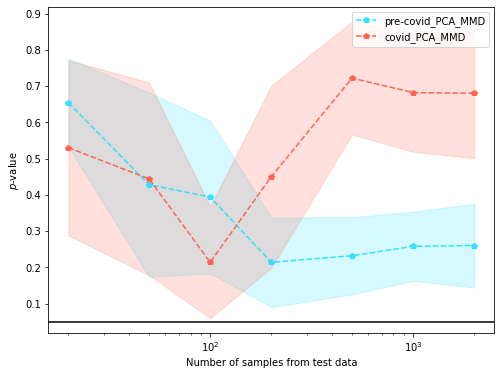

In [4]:
# Run shift experiments
if os.path.exists(PATH + "/mean_dr_md.pkl"):
    with open(PATH + "/mean_dr_md.pkl", "rb") as f:
        mean_dr_md = pickle.load(f)
else:
    mean_dr_md = np.ones(
        (len(SHIFTS), len(HOSPITALS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)

if os.path.exists(PATH + "/std_dr_md.pkl"):
    with open(PATH + "/std_dr_md.pkl", "rb") as f:
        std_dr_md = pickle.load(f)
else:
    std_dr_md = np.ones(
        (len(SHIFTS), len(HOSPITALS), len(DR_TECHNIQUES), len(MD_TESTS), len(SAMPLES))
    ) * (-1)

for si, SHIFT in enumerate(SHIFTS):
    for hi, HOSPITAL in enumerate(HOSPITALS):
        for di, DR_TECHNIQUE in enumerate(DR_TECHNIQUES):
            for mi, MD_TEST in enumerate(MD_TESTS):
                if np.any(mean_dr_md[si, hi, di, mi, :] == -1):
                    print(
                        "{} | {} | {} | {}".format(
                            SHIFT, HOSPITAL, DR_TECHNIQUE, MD_TEST
                        )
                    )
                    try:
                        mean_p_vals, std_p_vals = run_shift_experiment(
                            SHIFT,
                            OUTCOME,
                            [HOSPITAL],
                            PATH,
                            DR_TECHNIQUE,
                            MD_TEST,
                            SAMPLES,
                            DATASET,
                            SIGN_LEVEL,
                            NA_CUTOFF,
                            RANDOM_RUNS,
                            calc_acc=True,
                        )
                        mean_dr_md[si, hi, di, mi, :] = mean_p_vals
                        std_dr_md[si, hi, di, mi, :] = std_p_vals
                    except ValueError as e:
                        print("Value Error")
                        pass

DIM_RED = input("Select Pre-Processing: ")
MD_TEST = input("Select Two-Sample Testing: ")

fig = plt.figure(figsize=(8, 6))
for si, shift in enumerate(SHIFTS):
    for hi, hospital in enumerate(HOSPITALS):
        for di, dr_technique in enumerate(DR_TECHNIQUES):
            for mi, md_test in enumerate(MD_TESTS):
                if (
                    shift in SHIFT_BS
                    and hospital == HOSPITAL
                    and dr_technique == DIM_RED
                    and md_test == MD_TEST
                ):
                    errorfill(
                        np.array(SAMPLES[1:]),
                        mean_dr_md[si, hi, di, mi, 1:],
                        std_dr_md[si, hi, di, mi, 1:],
                        fmt=linestyles[di] + markers[di],
                        color=colorscale(colors[si], brightness[mi]),
                        label="%s" % "_".join([shift, dr_technique, md_test]),
                    )
plt.xlabel("Number of samples from test data")
plt.ylabel("$p$-value")
plt.axhline(y=SIGN_LEVEL, color="k")
plt.legend()
plt.show()

# Run shift experiments
if not os.path.exists(PATH + "/mean_dr_md.pkl"):
    with open(PATH + "/mean_dr_md.pkl", "wb") as f:
        pickle.dump(mean_dr_md, f)
if not os.path.exists(PATH + "/std_dr_md.pkl"):
    with open(PATH + "/std_dr_md.pkl", "wb") as f:
        pickle.dump(std_dr_md, f)

# Build Model #

In [5]:
(
    (X_train, y_train),
    (X_val, y_val),
    (X_test, y_test),
    feats,
    orig_dims,
) = import_dataset_hospital(
    SHIFT_EXPERIMENT, OUTCOME, [HOSPITAL], NA_CUTOFF, shuffle=True
)

MODEL_NAME = input("Select Model: ")
MODEL_PATH = PATH + "_".join([SHIFT_EXPERIMENT, OUTCOME, HOSPITAL, MODEL_NAME]) + ".pkl"
if os.path.exists(MODEL_PATH):
    optimised_model = pickle.load(open(MODEL_PATH, "rb"))
else:
    optimised_model = run_model(MODEL_NAME, X_train, y_train, X_val, y_val)

Select Model: xgb
Best eta: 0.3
Best g: 1.5
Best n: 7


### Performance on Source Data ###

<AxesSubplot:title={'center':'Average Precision: 0.894447'}, xlabel='Recall', ylabel='Precision'>

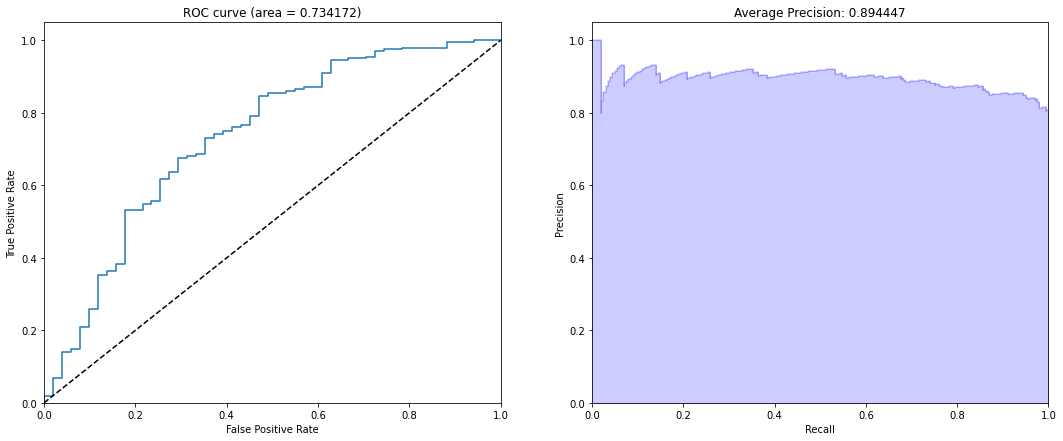

In [6]:
y_pred_prob = optimised_model.predict_proba(X_val)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)
avg_pr = average_precision_score(y_val, y_pred_prob)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
plot_roc(ax[0], fpr, tpr, roc_auc)
plot_pr(ax[1], recall, precision, avg_pr)

### Performance on Target Data ###

<AxesSubplot:title={'center':'Average Precision: 0.895099'}, xlabel='Recall', ylabel='Precision'>

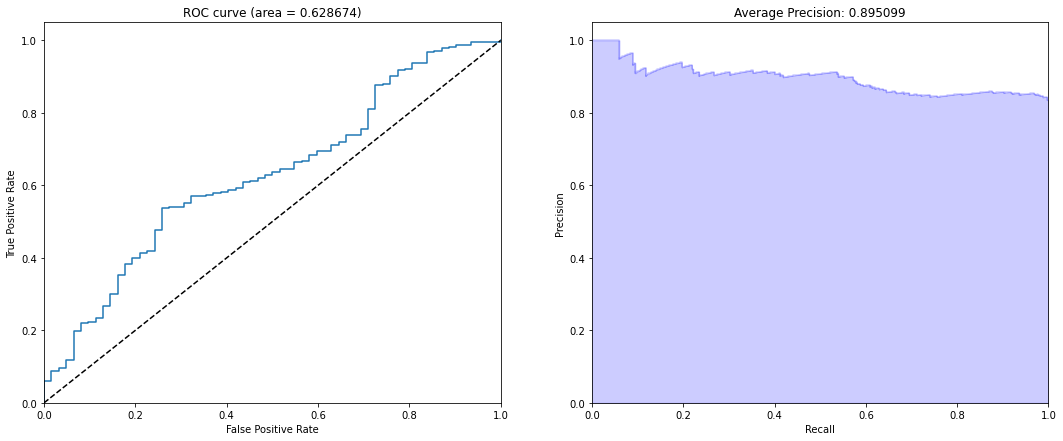

In [7]:
y_pred_prob = optimised_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
avg_pr = average_precision_score(y_test, y_pred_prob)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 7))
plot_roc(ax[0], fpr, tpr, roc_auc)
plot_pr(ax[1], recall, precision, avg_pr)

## Performance by Sample Size ##

In [8]:
def __unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [9]:
samp_metrics = np.ones((len(SAMPLES), RANDOM_RUNS, 2, 2)) * (-1)
for si, sample in enumerate(SAMPLES):
    for i in range(0, RANDOM_RUNS - 1):
        i = int(i)
        np.random.seed(i)
        X_val, y_val = __unison_shuffled_copies(X_val, y_val)
        X_test, y_test = __unison_shuffled_copies(X_test, y_test)

        y_val_pred_prob = optimised_model.predict_proba(X_val[:sample])[:, 1]
        val_fpr, val_tpr, val_thresholds = roc_curve(
            y_val[:sample], y_val_pred_prob, pos_label=1
        )
        val_roc_auc = auc(val_fpr, val_tpr)
        val_avg_pr = average_precision_score(y_val[:sample], y_val_pred_prob)

        y_test_pred_prob = optimised_model.predict_proba(X_test[:sample])[:, 1]
        test_fpr, test_tpr, test_thresholds = roc_curve(
            y_test[:sample], y_test_pred_prob, pos_label=1
        )
        test_roc_auc = auc(test_fpr, test_tpr)
        test_avg_pr = average_precision_score(y_test[:sample], y_test_pred_prob)

        samp_metrics[si, i, 0, :] = [val_roc_auc, val_avg_pr]
        samp_metrics[si, i, 1, :] = [test_roc_auc, test_avg_pr]

    mean_samp_metrics = np.mean(samp_metrics, axis=1)
    std_samp_metrics = np.std(samp_metrics, axis=1)

torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
No negative samples in y_true, false positive value should be meaningless
torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. In

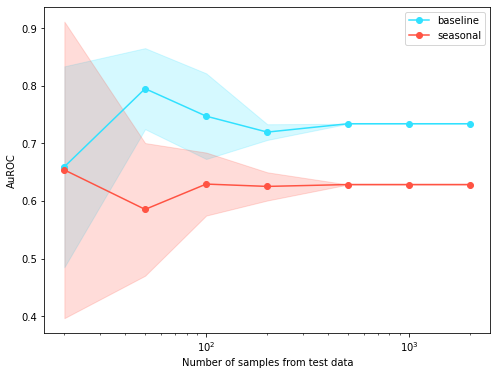

In [10]:
fig = plt.figure(figsize=(8, 6))
for si, shift in enumerate(["baseline", SHIFT]):
    for mi, metric in enumerate(["AuROC", "Avg Pr"]):
        if metric == "AuROC":
            errorfill(
                np.array(SAMPLES[1:]),
                mean_samp_metrics[1:, si, mi],
                std_samp_metrics[1:, si, mi],
                fmt=linestyles[mi] + markers[mi],
                color=colorscale(colors[si], brightness[si]),
                label="%s" % "_".join([shift]),
            )
plt.xlabel("Number of samples from test data")
plt.ylabel("AuROC")
plt.legend()
plt.show()

## Explain Difference in Model Predictions ## 

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


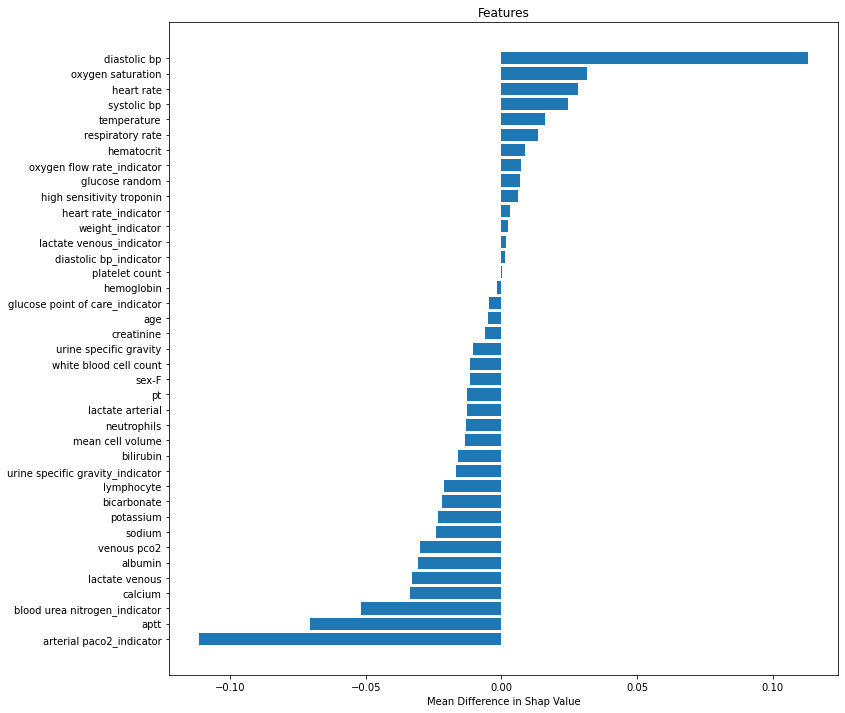

In [11]:
explainer = ShiftExplainer(optimised_model)
explainer.get_explainer()

X_val_df = pd.DataFrame(X_val, columns=feats)
val_shap_values = explainer.get_shap_values(X_val_df)
X_test_df = pd.DataFrame(X_test, columns=feats)
test_shap_values = explainer.get_shap_values(X_test_df)

diff = np.mean(np.abs(test_shap_values.values), axis=0) - np.mean(
    np.abs(val_shap_values.values), axis=0
)
diff_sorted, feats_sorted = zip(*sorted(zip(diff, feats), reverse=True))
diff_sorted, feats_sorted = zip(
    *(((x, y) for x, y in zip(diff_sorted, feats_sorted) if x != 0))
)
fig, ax = plt.subplots(figsize=(12, 12))
y_pos = np.arange(len(diff_sorted))
ax.barh(y_pos, diff_sorted, align="center")
ax.set_yticks(y_pos, labels=feats_sorted)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Mean Difference in Shap Value")
ax.set_title("Features")
plt.show()